# 4th Down Efficiency

### Business Problem: To create a machine learning algorithm that can predict the likelihood of a success or failure on a 4th down conversation attempt.

### The Data: The nflfastR data has conditions and results from every play from every game. This project will be using data from 2011 to 2020.

### The Plan:
#### 1) Explore and clean the data, dropping any columns that aren't needed and feature engineering for offensive and defensive strength.
#### 2) Transform the remaining data so that it can be modelled
#### 3) Run different types of models to find the best fit

# Data Exploration

## Import File and Set Conditions

In [68]:
import numpy as np
import pandas as pd

# enter desired years of data
YEARS = [2020,2019,2018,2017,2016,2015,2014,2013,2012,2011]

data = pd.DataFrame()

for i in YEARS:  
    # low_memory=False eliminates a warning
    i_data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(i) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

    # sort=True eliminates a warning and alphabetically sorts columns
    data = data.append(i_data, sort=True)

# give each row a unique index
data.reset_index(drop=True, inplace=True)

data.head()

aborted_play   air_epa  air_wpa  air_yards  assist_tackle  \
0             0       NaN      NaN        NaN            NaN   
1             0       NaN      NaN        NaN            0.0   
2             0 -0.132787      0.0        4.0            0.0   
3             0       NaN      NaN        NaN            0.0   
4             0       NaN      NaN        NaN            0.0   

  assist_tackle_1_player_id assist_tackle_1_player_name assist_tackle_1_team  \
0                       NaN                         NaN                  NaN   
1                       NaN                         NaN                  NaN   
2                       NaN                         NaN                  NaN   
3                       NaN                         NaN                  NaN   
4                       NaN                         NaN                  NaN   

  assist_tackle_2_player_id assist_tackle_2_player_name  ...  \
0                       NaN                         NaN  ...   
1                       NaN                         NaN  ...   
2                       NaN                         NaN  ...   
3                       NaN                         NaN  ...   
4                       NaN                         NaN  ...   

  xyac_median_yardage xyac_success   yac_epa   yac_wpa yardline_100  \
0                 NaN          NaN       NaN       NaN          NaN   
1                 NaN          NaN       NaN       NaN         35.0   
2                 2.0     0.619306  1.427625  0.033715         75.0   
3                 NaN          NaN       NaN       NaN         55.0   
4                 NaN          NaN       NaN       NaN         41.0   

  yards_after_catch yards_gained ydsnet  ydstogo   yrdln  
0               NaN          NaN    NaN        0  ARI 35  
1               NaN          0.0   41.0        0  ARI 35  
2               1.0          5.0   41.0       10   SF 25  
3               NaN         14.0   41.0       10   SF 45  
4               NaN          2.0   41.0       10  ARI 41  

[5 rows x 363 columns]

In [69]:
# model only focuses offensive 4th down plays
data['down'].value_counts()

1.0    162396
2.0    121007
3.0     77083
4.0     41145
Name: down, dtype: int64

In [70]:
data = data[data['down'] == 4.0]
data['down'].value_counts()

4.0    41145
Name: down, dtype: int64

In [71]:
# a special teams play converstion that is not a punt or kick could be considered a fake punt or kick
# these plays will not be considered conversion attempts for this model

data['special_teams_play'].value_counts()

1    35490
0     5655
Name: special_teams_play, dtype: int64

In [72]:
data = data[data['special_teams_play'] == 0]
data['special_teams_play'].value_counts()

0    5655
Name: special_teams_play, dtype: int64

In [73]:
data['play_type'].value_counts()

pass        3281
run         1685
no_play      640
qb_kneel      33
punt           3
Name: play_type, dtype: int64

In [74]:
# no play means a penalty and the conversion is tried again
# qb_kneel is to run the clock out and is not considered a conversion attempt in this model
# qb_spike is to stop the clock and is not considered a conversion attempt in this model
# offenses will fake a conversation and their qb will punt
# the model is not concerned with these plays

data = data[~(data['play_type'].isin(['no_play', 'qb_kneel', 'qb_spike', 'punt']))]
data['play_type'].value_counts()

pass    3281
run     1685
Name: play_type, dtype: int64

In [75]:
data['season_type'].value_counts()

REG     4727
POST     252
Name: season_type, dtype: int64

In [76]:
data = data[data['season_type'] == 'REG']
data['season_type'].value_counts()

REG    4727
Name: season_type, dtype: int64

## Drop Useless Columns

In [77]:
list(data)

['aborted_play',
 'air_epa',
 'air_wpa',
 'air_yards',
 'assist_tackle',
 'assist_tackle_1_player_id',
 'assist_tackle_1_player_name',
 'assist_tackle_1_team',
 'assist_tackle_2_player_id',
 'assist_tackle_2_player_name',
 'assist_tackle_2_team',
 'assist_tackle_3_player_id',
 'assist_tackle_3_player_name',
 'assist_tackle_3_team',
 'assist_tackle_4_player_id',
 'assist_tackle_4_player_name',
 'assist_tackle_4_team',
 'away_coach',
 'away_score',
 'away_team',
 'away_timeouts_remaining',
 'away_wp',
 'away_wp_post',
 'blocked_player_id',
 'blocked_player_name',
 'comp_air_epa',
 'comp_air_wpa',
 'comp_yac_epa',
 'comp_yac_wpa',
 'complete_pass',
 'cp',
 'cpoe',
 'def_wp',
 'defensive_extra_point_attempt',
 'defensive_extra_point_conv',
 'defensive_two_point_attempt',
 'defensive_two_point_conv',
 'defteam',
 'defteam_score',
 'defteam_score_post',
 'defteam_timeouts_remaining',
 'desc',
 'div_game',
 'down',
 'drive',
 'drive_end_transition',
 'drive_end_yard_line',
 'drive_ended_with_

In [78]:
df = data[['season', 'week', 'home_team', 'away_team', 'posteam_type', 'posteam', 'defteam', 'yardline_100', 
           'half_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'sp', 'goal_to_go', 'ydstogo', 'ydsnet', 'yards_gained', 
           'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 
           'yards_after_catch', 'run_location', 'run_gap', 'timeout', 'timeout_team', 'posteam_timeouts_remaining', 
           'defteam_timeouts_remaining', 'score_differential', 'score_differential_post', 'no_score_prob', 'opp_td_prob', 
           'td_prob', 'ep', 'epa', 'wp', 'wpa', 'complete_pass', 'incomplete_pass', 'interception', 'tackled_for_loss', 
           'fumble_lost', 'qb_hit', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'fumble', 'series', 
           'drive_play_count', 'drive_inside20', 'div_game', 'stadium', 'surface', 'roof', 'pass', 'rush', 'success']].copy()

In [79]:
df.head(50)

season  week home_team away_team posteam_type posteam defteam  \
49      2020     1        SF       ARI         home      SF     ARI   
181     2020     1        SF       ARI         home      SF     ARI   
208     2020     1       DET       CHI         away     CHI     DET   
323     2020     1       DET       CHI         away     CHI     DET   
511     2020     1       BAL       CLE         away     CLE     BAL   
533     2020     1       BAL       CLE         away     CLE     BAL   
584     2020     1        LA       DAL         home      LA     DAL   
708     2020     1        LA       DAL         away     DAL      LA   
737     2020     1        LA       DAL         away     DAL      LA   
743     2020     1        LA       DAL         away     DAL      LA   
786     2020     1       MIN        GB         away      GB     MIN   
812     2020     1       MIN        GB         away      GB     MIN   
854     2020     1       MIN        GB         home     MIN      GB   
950     2020     1        KC       HOU         home      KC     HOU   
1057    2020     1        KC       HOU         away     HOU      KC   
1117    2020     1       JAX       IND         away     IND     JAX   
1183    2020     1       JAX       IND         away     IND     JAX   
1248    2020     1       JAX       IND         away     IND     JAX   
1300    2020     1       CIN       LAC         away     LAC     CIN   
1336    2020     1       CIN       LAC         away     LAC     CIN   
1570    2020     1       CAR        LV         home     CAR      LV   
1611    2020     1       CAR        LV         home     CAR      LV   
1757    2020     1        NE       MIA         home      NE     MIA   
1831    2020     1       BUF       NYJ         home     BUF     NYJ   
2101    2020     1       WAS       PHI         away     PHI     WAS   
2124    2020     1       WAS       PHI         home     WAS     PHI   
2133    2020     1       WAS       PHI         away     PHI     WAS   
2271    2020     1       NYG       PIT         home     NYG     PIT   
2332    2020     1       NYG       PIT         away     PIT     NYG   
2366    2020     1       ATL       SEA         home     ATL     SEA   
2443    2020     1       ATL       SEA         away     SEA     ATL   
2464    2020     1       ATL       SEA         home     ATL     SEA   
2494    2020     1       ATL       SEA         home     ATL     SEA   
2702    2020     1        NO        TB         away      TB      NO   
2715    2020     1        NO        TB         home      NO      TB   
2784    2020     1       DEN       TEN         home     DEN     TEN   
2845    2020     1       DEN       TEN         away     TEN     DEN   
2968    2020     2       DAL       ATL         away     ATL     DAL   
3045    2020     2       DAL       ATL         away     ATL     DAL   
3144    2020     2       HOU       BAL         home     HOU     BAL   
3240    2020     2       HOU       BAL         away     BAL     HOU   
3257    2020     2       HOU       BAL         away     BAL     HOU   
3405    2020     2       MIA       BUF         home     MIA     BUF   
3596    2020     2        TB       CAR         away     CAR      TB   
3654    2020     2       CLE       CIN         away     CIN     CLE   
3748    2020     2       CLE       CIN         home     CLE     CIN   
3754    2020     2       CLE       CIN         home     CLE     CIN   
3771    2020     2       CLE       CIN         away     CIN     CLE   
3797    2020     2       CLE       CIN         away     CIN     CLE   
3822    2020     2       CLE       CIN         away     CIN     CLE   

      yardline_100  half_seconds_remaining game_half  ...  series  \
49             1.0                   757.0     Half1  ...      16   
181           16.0                    37.0     Half2  ...      62   
208           34.0                  1442.0     Half1  ...       6   
323           10.0                   900.0     Half2  ...      49   
511           28.0                  108

In [80]:
df.describe()

season         week  yardline_100  half_seconds_remaining  \
count  4727.000000  4727.000000   4727.000000             4727.000000   
mean   2015.872858     9.408081     35.793738              545.254072   
std       2.921261     4.989363     21.631194              489.389464   
min    2011.000000     1.000000      1.000000                0.000000   
25%    2013.000000     5.000000     19.000000              120.000000   
50%    2016.000000    10.000000     36.000000              385.000000   
75%    2019.000000    14.000000     50.000000              900.000000   
max    2020.000000    17.000000     97.000000             1800.000000   

             drive         qtr    down           sp   goal_to_go      ydstogo  \
count  4727.000000  4727.00000  4727.0  4727.000000  4727.000000  4727.000000   
mean     15.900994     3.22234     4.0     0.090967     0.103871     4.472181   
std       7.147939     1.06271     0.0     0.287592     0.305126     4.789653   
min       1.000000     1.00000     4.0     0.000000     0.000000     1.000000   
25%      11.000000     2.00000     4.0     0.000000     0.000000     1.000000   
50%      17.000000     4.00000     4.0     0.000000     0.000000     2.000000   
75%      21.000000     4.00000     4.0     0.000000     0.000000     6.000000   
max      34.000000     5.00000     4.0     1.000000     1.000000    43.000000   

       ...  pass_touchdown  rush_touchdown       fumble       series  \
count  ...     4716.000000     4716.000000  4716.000000  4727.000000   
mean   ...        0.056616        0.031807     0.026718    40.487413   
std    ...        0.231131        0.175504     0.161274    17.447709   
min    ...        0.000000        0.000000     0.000000     1.000000   
25%    ...        0.000000        0.000000     0.000000    27.000000   
50%    ...        0.000000        0.000000     0.000000    46.000000   
75%    ...        0.000000        0.000000     0.000000    54.000000   
max    ...        1.000000        1.000000     1.000000    83.000000   

       drive_play_count  drive_inside20     div_game         pass  \
count       4727.000000     4727.000000  4727.000000  4716.000000   
mean           9.341654        0.474297     0.386715     0.686599   
std            3.516999        0.499392     0.487049     0.463925   
min            3.000000        0.000000     0.000000     0.000000   
25%            7.000000        0.000000     0.000000     0.000000   
50%            9.000000        0.000000     0.000000     1.000000   
75%           12.000000        1.000000     1.000000     1.000000   
max           21.000000        1.000000     1.000000     1.000000   

              rush      success  
count  4727.000000  4713.000000  
mean      0.312672     0.496923  
std       0.463631     0.500044  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000  

[8 rows x 48 columns]

In [81]:
df['posteam'].value_counts()

PHI    211
CLE    203
JAX    187
NYG    174
BAL    163
CHI    161
ATL    158
GB     157
CIN    154
WAS    154
HOU    151
IND    150
MIN    148
MIA    148
NYJ    145
LV     145
CAR    142
BUF    142
TB     140
SF     140
ARI    138
DET    137
DAL    137
NO     137
LA     136
NE     136
DEN    135
TEN    129
KC     121
LAC    119
SEA    116
PIT    113
Name: posteam, dtype: int64

In [82]:
df['defteam'].value_counts()

NE     188
KC     188
MIN    184
GB     182
NO     170
CHI    168
BAL    167
SF     163
TEN    161
PIT    156
CIN    151
ATL    151
DAL    150
NYG    148
MIA    148
LA     147
PHI    147
DEN    147
WAS    145
CAR    143
CLE    143
BUF    135
ARI    135
HOU    133
SEA    130
TB     129
DET    128
IND    123
NYJ    122
LAC    121
JAX    112
LV     112
Name: defteam, dtype: int64

## Feature Engineer Offensive and Defensive Rankings For Each Season

### Using data from The Football Database, individual rankings will be assigned to offensive and defensive teams for every season

In [83]:
def off_rank(i):
    if i['season'] == 2011:
        if i['posteam'] == 'NO':
            val = 1
        elif i['posteam'] == 'NE':
            val = 2
        elif i['posteam'] == 'GB':
            val = 3
        elif i['posteam'] == 'PHI':
            val = 4
        elif i['posteam'] == 'DET':
            val = 5
        elif i['posteam'] == 'LAC':
            val = 6
        elif i['posteam'] == 'CAR':
            val = 7
        elif i['posteam'] == 'NYG':
            val = 8
        elif i['posteam'] == 'LV':
            val = 9
        elif i['posteam'] == 'ATL':
            val = 10
        elif i['posteam'] == 'DAL':
            val = 11
        elif i['posteam'] == 'PIT':
            val = 12
        elif i['posteam'] == 'HOU':
            val = 13
        elif i['posteam'] == 'BUF':
            val = 14
        elif i['posteam'] == 'BAL':
            val = 15
        elif i['posteam'] == 'WAS':
            val = 16
        elif i['posteam'] == 'TEN':
            val = 17
        elif i['posteam'] == 'MIN':
            val = 18
        elif i['posteam'] == 'ARI':
            val = 19
        elif i['posteam'] == 'CIN':
            val = 20
        elif i['posteam'] == 'TB':
            val = 21
        elif i['posteam'] == 'MIA':
            val = 22
        elif i['posteam'] == 'DEN':
            val = 23
        elif i['posteam'] == 'CHI':
            val = 24
        elif i['posteam'] == 'NYJ':
            val = 25
        elif i['posteam'] == 'SF':
            val = 26
        elif i['posteam'] == 'KC':
            val = 27
        elif i['posteam'] == 'SEA':
            val = 28
        elif i['posteam'] == 'CLE':
            val = 29
        elif i['posteam'] == 'IND':
            val = 30
        elif i['posteam'] == 'LAR':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2012:
        if i['posteam'] == 'NE':
            val = 1
        elif i['posteam'] == 'NO':
            val = 2
        elif i['posteam'] == 'DET':
            val = 3
        elif i['posteam'] == 'DEN':
            val = 4
        elif i['posteam'] == 'WAS':
            val = 5
        elif i['posteam'] == 'DAL':
            val = 6
        elif i['posteam'] == 'HOU':
            val = 7
        elif i['posteam'] == 'ATL':
            val = 8
        elif i['posteam'] == 'TB':
            val = 9
        elif i['posteam'] == 'IND':
            val = 10
        elif i['posteam'] == 'SF':
            val = 11
        elif i['posteam'] == 'CAR':
            val = 12
        elif i['posteam'] == 'GB':
            val = 13
        elif i['posteam'] == 'NYG':
            val = 14
        elif i['posteam'] == 'PHI':
            val = 15
        elif i['posteam'] == 'BAL':
            val = 16
        elif i['posteam'] == 'SEA':
            val = 17
        elif i['posteam'] == 'LV':
            val = 18
        elif i['posteam'] == 'BUF':
            val = 19
        elif i['posteam'] == 'MIN':
            val = 20
        elif i['posteam'] == 'PIT':
            val = 21
        elif i['posteam'] == 'CIN':
            val = 22
        elif i['posteam'] == 'LAR':
            val = 23
        elif i['posteam'] == 'KC':
            val = 24
        elif i['posteam'] == 'CLE':
            val = 25
        elif i['posteam'] == 'TEN':
            val = 26
        elif i['posteam'] == 'MIA':
            val = 27
        elif i['posteam'] == 'CHI':
            val = 28
        elif i['posteam'] == 'JAX':
            val = 29
        elif i['posteam'] == 'NYJ':
            val = 30
        elif i['posteam'] == 'LAC':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2013:
        if i['posteam'] == 'DEN':
            val = 1
        elif i['posteam'] == 'PHI':
            val = 2
        elif i['posteam'] == 'GB':
            val = 3
        elif i['posteam'] == 'NO':
            val = 4
        elif i['posteam'] == 'LAC':
            val = 5
        elif i['posteam'] == 'DET':
            val = 6
        elif i['posteam'] == 'NE':
            val = 7
        elif i['posteam'] == 'CHI':
            val = 8
        elif i['posteam'] == 'WAS':
            val = 9
        elif i['posteam'] == 'CIN':
            val = 10
        elif i['posteam'] == 'HOU':
            val = 11
        elif i['posteam'] == 'ARI':
            val = 12
        elif i['posteam'] == 'MIN':
            val = 13
        elif i['posteam'] == 'ATL':
            val = 14
        elif i['posteam'] == 'IND':
            val = 15
        elif i['posteam'] == 'DAL':
            val = 16
        elif i['posteam'] == 'CLE':
            val = 17
        elif i['posteam'] == 'SEA':
            val = 18
        elif i['posteam'] == 'BUF':
            val = 19
        elif i['posteam'] == 'PIT':
            val = 20
        elif i['posteam'] == 'KC':
            val = 21
        elif i['posteam'] == 'TEN':
            val = 22
        elif i['posteam'] == 'LV':
            val = 23
        elif i['posteam'] == 'SF':
            val = 24
        elif i['posteam'] == 'NYJ':
            val = 25
        elif i['posteam'] == 'CAR':
            val = 26
        elif i['posteam'] == 'MIA':
            val = 27
        elif i['posteam'] == 'NYG':
            val = 28
        elif i['posteam'] == 'BAL':
            val = 29
        elif i['posteam'] == 'LAR':
            val = 30
        elif i['posteam'] == 'JAX':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2014:
        if i['posteam'] == 'NO':
            val = 1
        elif i['posteam'] == 'PIT':
            val = 2
        elif i['posteam'] == 'IND':
            val = 3
        elif i['posteam'] == 'DEN':
            val = 4
        elif i['posteam'] == 'PHI':
            val = 5
        elif i['posteam'] == 'GB':
            val = 6
        elif i['posteam'] == 'DAL':
            val = 7
        elif i['posteam'] == 'ATL':
            val = 8
        elif i['posteam'] == 'SEA':
            val = 9
        elif i['posteam'] == 'NYG':
            val = 10
        elif i['posteam'] == 'NE':
            val = 11
        elif i['posteam'] == 'BAL':
            val = 12
        elif i['posteam'] == 'WAS':
            val = 13
        elif i['posteam'] == 'MIA':
            val = 14
        elif i['posteam'] == 'CIN':
            val = 15
        elif i['posteam'] == 'CAR':
            val = 16
        elif i['posteam'] == 'HOU':
            val = 17
        elif i['posteam'] == 'LAC':
            val = 18
        elif i['posteam'] == 'DET':
            val = 19
        elif i['posteam'] == 'SF':
            val = 20
        elif i['posteam'] == 'CHI':
            val = 21
        elif i['posteam'] == 'NYJ':
            val = 22
        elif i['posteam'] == 'CLE':
            val = 23
        elif i['posteam'] == 'ARI':
            val = 24
        elif i['posteam'] == 'KC':
            val = 25
        elif i['posteam'] == 'BUF':
            val = 26
        elif i['posteam'] == 'MIN':
            val = 27
        elif i['posteam'] == 'LAR':
            val = 28
        elif i['posteam'] == 'TEN':
            val = 29
        elif i['posteam'] == 'TB':
            val = 30
        elif i['posteam'] == 'JAX':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2015:
        if i['posteam'] == 'ARI':
            val = 1
        elif i['posteam'] == 'NO':
            val = 2
        elif i['posteam'] == 'PIT':
            val = 3
        elif i['posteam'] == 'SEA':
            val = 4
        elif i['posteam'] == 'TB':
            val = 5
        elif i['posteam'] == 'NE':
            val = 6
        elif i['posteam'] == 'ATL':
            val = 7
        elif i['posteam'] == 'NYG':
            val = 8
        elif i['posteam'] == 'SEA':
            val = 9
        elif i['posteam'] == 'NYG':
            val = 10
        elif i['posteam'] == 'NE':
            val = 11
        elif i['posteam'] == 'BAL':
            val = 12
        elif i['posteam'] == 'WAS':
            val = 13
        elif i['posteam'] == 'MIA':
            val = 14
        elif i['posteam'] == 'CIN':
            val = 15
        elif i['posteam'] == 'CAR':
            val = 16
        elif i['posteam'] == 'HOU':
            val = 17
        elif i['posteam'] == 'LAC':
            val = 18
        elif i['posteam'] == 'DET':
            val = 19
        elif i['posteam'] == 'SF':
            val = 20
        elif i['posteam'] == 'CHI':
            val = 21
        elif i['posteam'] == 'NYJ':
            val = 22
        elif i['posteam'] == 'CLE':
            val = 23
        elif i['posteam'] == 'ARI':
            val = 24
        elif i['posteam'] == 'KC':
            val = 25
        elif i['posteam'] == 'BUF':
            val = 26
        elif i['posteam'] == 'MIN':
            val = 27
        elif i['posteam'] == 'LAR':
            val = 28
        elif i['posteam'] == 'TEN':
            val = 29
        elif i['posteam'] == 'TB':
            val = 30
        elif i['posteam'] == 'JAX':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2016:
        if i['posteam'] == 'NO':
            val = 1
        elif i['posteam'] == 'ATL':
            val = 2
        elif i['posteam'] == 'WAS':
            val = 3
        elif i['posteam'] == 'NE':
            val = 4
        elif i['posteam'] == 'DAL':
            val = 5
        elif i['posteam'] == 'LV':
            val = 6
        elif i['posteam'] == 'PIT':
            val = 7
        elif i['posteam'] == 'GB':
            val = 8
        elif i['posteam'] == 'ARI':
            val = 9
        elif i['posteam'] == 'IND':
            val = 10
        elif i['posteam'] == 'TEN':
            val = 11
        elif i['posteam'] == 'SEA':
            val = 12
        elif i['posteam'] == 'CIN':
            val = 13
        elif i['posteam'] == 'LAC':
            val = 14
        elif i['posteam'] == 'CHI':
            val = 15
        elif i['posteam'] == 'BUF':
            val = 16
        elif i['posteam'] == 'BAL':
            val = 17
        elif i['posteam'] == 'TB':
            val = 18
        elif i['posteam'] == 'CAR':
            val = 19
        elif i['posteam'] == 'KC':
            val = 20
        elif i['posteam'] == 'DET':
            val = 21
        elif i['posteam'] == 'PHI':
            val = 22
        elif i['posteam'] == 'JAX':
            val = 23
        elif i['posteam'] == 'MIA':
            val = 24
        elif i['posteam'] == 'NYG':
            val = 25
        elif i['posteam'] == 'NYJ':
            val = 26
        elif i['posteam'] == 'DEN':
            val = 27
        elif i['posteam'] == 'MIN':
            val = 28
        elif i['posteam'] == 'HOU':
            val = 29
        elif i['posteam'] == 'CLE':
            val = 30
        elif i['posteam'] == 'SF':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2017:
        if i['posteam'] == 'NE':
            val = 1
        elif i['posteam'] == 'NO':
            val = 2
        elif i['posteam'] == 'PIT':
            val = 3
        elif i['posteam'] == 'LAC':
            val = 4
        elif i['posteam'] == 'KC':
            val = 5
        elif i['posteam'] == 'JAX':
            val = 6
        elif i['posteam'] == 'PHI':
            val = 7
        elif i['posteam'] == 'ATL':
            val = 8
        elif i['posteam'] == 'TB':
            val = 9
        elif i['posteam'] == 'LAR':
            val = 10
        elif i['posteam'] == 'MIN':
            val = 11
        elif i['posteam'] == 'SF':
            val = 12
        elif i['posteam'] == 'DET':
            val = 13
        elif i['posteam'] == 'DAL':
            val = 14
        elif i['posteam'] == 'SEA':
            val = 15
        elif i['posteam'] == 'WAS':
            val = 16
        elif i['posteam'] == 'DEN':
            val = 17
        elif i['posteam'] == 'LV':
            val = 18
        elif i['posteam'] == 'CAR':
            val = 19
        elif i['posteam'] == 'HOU':
            val = 20
        elif i['posteam'] == 'NYG':
            val = 21
        elif i['posteam'] == 'ARI':
            val = 22
        elif i['posteam'] == 'TEN':
            val = 23
        elif i['posteam'] == 'CLE':
            val = 24
        elif i['posteam'] == 'MIA':
            val = 25
        elif i['posteam'] == 'GB':
            val = 26
        elif i['posteam'] == 'BAL':
            val = 27
        elif i['posteam'] == 'NYJ':
            val = 28
        elif i['posteam'] == 'BUF':
            val = 29
        elif i['posteam'] == 'CHI':
            val = 30
        elif i['posteam'] == 'IND':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2018:
        if i['posteam'] == 'KC':
            val = 1
        elif i['posteam'] == 'LAR':
            val = 2
        elif i['posteam'] == 'TB':
            val = 3
        elif i['posteam'] == 'PIT':
            val = 4
        elif i['posteam'] == 'NE':
            val = 5
        elif i['posteam'] == 'ATL':
            val = 6
        elif i['posteam'] == 'IND':
            val = 7
        elif i['posteam'] == 'NO':
            val = 8
        elif i['posteam'] == 'BAL':
            val = 9
        elif i['posteam'] == 'CAR':
            val = 10
        elif i['posteam'] == 'LAC':
            val = 11
        elif i['posteam'] == 'GB':
            val = 12
        elif i['posteam'] == 'CLE':
            val = 13
        elif i['posteam'] == 'PHI':
            val = 14
        elif i['posteam'] == 'HOU':
            val = 15
        elif i['posteam'] == 'SF':
            val = 16
        elif i['posteam'] == 'NYG':
            val = 17
        elif i['posteam'] == 'SEA':
            val = 18
        elif i['posteam'] == 'DEN':
            val = 19
        elif i['posteam'] == 'MIN':
            val = 20
        elif i['posteam'] == 'CHI':
            val = 21
        elif i['posteam'] == 'DAL':
            val = 22
        elif i['posteam'] == 'LV':
            val = 23
        elif i['posteam'] == 'DET':
            val = 24
        elif i['posteam'] == 'TEN':
            val = 25
        elif i['posteam'] == 'CIN':
            val = 26
        elif i['posteam'] == 'JAX':
            val = 27
        elif i['posteam'] == 'WAS':
            val = 28
        elif i['posteam'] == 'NYJ':
            val = 29
        elif i['posteam'] == 'BUF':
            val = 30
        elif i['posteam'] == 'MIA':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2019:
        if i['posteam'] == 'DAL':
            val = 1
        elif i['posteam'] == 'BAL':
            val = 2
        elif i['posteam'] == 'TB':
            val = 3
        elif i['posteam'] == 'SF':
            val = 4
        elif i['posteam'] == 'ATL':
            val = 5
        elif i['posteam'] == 'KC':
            val = 6
        elif i['posteam'] == 'LAR':
            val = 7
        elif i['posteam'] == 'SEA':
            val = 8
        elif i['posteam'] == 'NO':
            val = 9
        elif i['posteam'] == 'LAC':
            val = 10
        elif i['posteam'] == 'LV':
            val = 11
        elif i['posteam'] == 'TEN':
            val = 12
        elif i['posteam'] == 'HOU':
            val = 13
        elif i['posteam'] == 'PHI':
            val = 14
        elif i['posteam'] == 'NE':
            val = 15
        elif i['posteam'] == 'MIN':
            val = 16
        elif i['posteam'] == 'DET':
            val = 17
        elif i['posteam'] == 'GB':
            val = 18
        elif i['posteam'] == 'CAR':
            val = 19
        elif i['posteam'] == 'JAX':
            val = 20
        elif i['posteam'] == 'ARI':
            val = 21
        elif i['posteam'] == 'CLE':
            val = 22
        elif i['posteam'] == 'NYG':
            val = 23
        elif i['posteam'] == 'BUF':
            val = 24
        elif i['posteam'] == 'IND':
            val = 25
        elif i['posteam'] == 'CIN':
            val = 26
        elif i['posteam'] == 'MIA':
            val = 27
        elif i['posteam'] == 'DEN':
            val = 28
        elif i['posteam'] == 'CHI':
            val = 29
        elif i['posteam'] == 'PIT':
            val = 30
        elif i['posteam'] == 'WAS':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2020:
        if i['posteam'] == 'KC':
            val = 1
        elif i['posteam'] == 'BUF':
            val = 2
        elif i['posteam'] == 'TEN':
            val = 3
        elif i['posteam'] == 'MIN':
            val = 4
        elif i['posteam'] == 'GB':
            val = 5
        elif i['posteam'] == 'ARI':
            val = 6
        elif i['posteam'] == 'TB':
            val = 7
        elif i['posteam'] == 'LV':
            val = 8
        elif i['posteam'] == 'LAC':
            val = 9
        elif i['posteam'] == 'IND':
            val = 10
        elif i['posteam'] == 'LAR':
            val = 11
        elif i['posteam'] == 'NO':
            val = 12
        elif i['posteam'] == 'HOU':
            val = 13
        elif i['posteam'] == 'DAL':
            val = 14
        elif i['posteam'] == 'SF':
            val = 15
        elif i['posteam'] == 'CLE':
            val = 16
        elif i['posteam'] == 'SEA':
            val = 17
        elif i['posteam'] == 'ATL':
            val = 18
        elif i['posteam'] == 'BAL':
            val = 19
        elif i['posteam'] == 'DET':
            val = 20
        elif i['posteam'] == 'CAR':
            val = 21
        elif i['posteam'] == 'MIA':
            val = 22
        elif i['posteam'] == 'DEN':
            val = 23
        elif i['posteam'] == 'PHI':
            val = 24
        elif i['posteam'] == 'PIT':
            val = 25
        elif i['posteam'] == 'CHI':
            val = 26
        elif i['posteam'] == 'NE':
            val = 27
        elif i['posteam'] == 'JAX':
            val = 28
        elif i['posteam'] == 'CIN':
            val = 29
        elif i['posteam'] == 'WAS':
            val = 30
        elif i['posteam'] == 'NYG':
            val = 31
        else:
            val = 32
        return val
    else:
        return

In [84]:
df['off_rank'] = df.apply(off_rank, axis=1)

In [85]:
df['off_rank'].head(100)

49      15
181     15
208     26
323     26
511     16
533     16
584     32
708     14
737     14
743     14
786      5
812      5
854      4
950      1
1057    13
1117    10
1183    10
1248    10
1300     9
1336     9
1570    21
1611    21
1757    27
1831     2
2101    24
2124    30
2133    24
2271    31
2332    25
2366    18
        ..
5559    32
5638    32
5728    30
5776     6
5800     6
6179    26
6187    26
6574    14
6608    14
6644    17
6690     6
6733    20
6948     5
6986     5
7020    12
7125    25
7186    25
7321     1
7356    19
7371     1
7402     2
7462    32
7766    22
7786    28
7839    28
7865    28
7992    10
8045    32
8146    31
8173    31
Name: off_rank, Length: 100, dtype: int64

In [86]:
df['off_rank'].unique()

array([15, 26, 16, 32, 14,  5,  4,  1, 13, 10,  9, 21, 27,  2, 24, 30, 31,
       25, 18, 17,  7, 12, 23,  3, 19, 22, 29, 20, 28,  8,  6, 11],
      dtype=int64)

In [87]:
def def_rank(i):
    if i['season'] == 2011:
        if i['defteam'] == 'PIT':
            val = 1
        elif i['defteam'] == 'HOU':
            val = 2
        elif i['defteam'] == 'BAL':
            val = 3
        elif i['defteam'] == 'SF':
            val = 4
        elif i['defteam'] == 'NYJ':
            val = 5
        elif i['defteam'] == 'JAX':
            val = 6
        elif i['defteam'] == 'CIN':
            val = 7
        elif i['defteam'] == 'PHI':
            val = 8
        elif i['defteam'] == 'SEA':
            val = 9
        elif i['defteam'] == 'CLE':
            val = 10
        elif i['defteam'] == 'KC':
            val = 11
        elif i['defteam'] == 'ATL':
            val = 12
        elif i['defteam'] == 'WAS':
            val = 13
        elif i['defteam'] == 'DAL':
            val = 14
        elif i['defteam'] == 'MIA':
            val = 15
        elif i['defteam'] == 'LAC':
            val = 16
        elif i['defteam'] == 'CHI':
            val = 17
        elif i['defteam'] == 'ARI':
            val = 18
        elif i['defteam'] == 'TEN':
            val = 19
        elif i['defteam'] == 'DEN':
            val = 20
        elif i['defteam'] == 'MIN':
            val = 21
        elif i['defteam'] == 'LAR':
            val = 22
        elif i['defteam'] == 'DET':
            val = 23
        elif i['defteam'] == 'NO':
            val = 24
        elif i['defteam'] == 'IND':
            val = 25
        elif i['defteam'] == 'BUF':
            val = 26
        elif i['defteam'] == 'NYG':
            val = 27
        elif i['defteam'] == 'CAR':
            val = 28
        elif i['defteam'] == 'LV':
            val = 29
        elif i['defteam'] == 'TB':
            val = 30
        elif i['defteam'] == 'NE':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2012:
        if i['defteam'] == 'PIT':
            val = 1
        elif i['defteam'] == 'DEN':
            val = 2
        elif i['defteam'] == 'SF':
            val = 3
        elif i['defteam'] == 'SEA':
            val = 4
        elif i['defteam'] == 'CHI':
            val = 5
        elif i['defteam'] == 'CIN':
            val = 6
        elif i['defteam'] == 'HOU':
            val = 7
        elif i['defteam'] == 'NYJ':
            val = 8
        elif i['defteam'] == 'LAC':
            val = 9
        elif i['defteam'] == 'CAR':
            val = 10
        elif i['defteam'] == 'GB':
            val = 11
        elif i['defteam'] == 'ARI':
            val = 12
        elif i['defteam'] == 'DET':
            val = 13
        elif i['defteam'] == 'LAR':
            val = 14
        elif i['defteam'] == 'PHI':
            val = 15
        elif i['defteam'] == 'MIN':
            val = 16
        elif i['defteam'] == 'BAL':
            val = 17
        elif i['defteam'] == 'LV':
            val = 18
        elif i['defteam'] == 'DAL':
            val = 19
        elif i['defteam'] == 'KC':
            val = 20
        elif i['defteam'] == 'MIA':
            val = 21
        elif i['defteam'] == 'BUF':
            val = 22
        elif i['defteam'] == 'CLE':
            val = 23
        elif i['defteam'] == 'ATL':
            val = 24
        elif i['defteam'] == 'NE':
            val = 25
        elif i['defteam'] == 'IND':
            val = 26
        elif i['defteam'] == 'TEN':
            val = 27
        elif i['defteam'] == 'WAS':
            val = 28
        elif i['defteam'] == 'TB':
            val = 29
        elif i['defteam'] == 'JAX':
            val = 30
        elif i['defteam'] == 'NYG':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2013:
        if i['defteam'] == 'SEA':
            val = 1
        elif i['defteam'] == 'CAR':
            val = 2
        elif i['defteam'] == 'CIN':
            val = 3
        elif i['defteam'] == 'NO':
            val = 4
        elif i['defteam'] == 'SF':
            val = 5
        elif i['defteam'] == 'ARI':
            val = 6
        elif i['defteam'] == 'HOU':
            val = 7
        elif i['defteam'] == 'NYG':
            val = 8
        elif i['defteam'] == 'CLE':
            val = 9
        elif i['defteam'] == 'BUF':
            val = 10
        elif i['defteam'] == 'NYJ':
            val = 11
        elif i['defteam'] == 'BAL':
            val = 12
        elif i['defteam'] == 'PIT':
            val = 13
        elif i['defteam'] == 'TEN':
            val = 14
        elif i['defteam'] == 'LAR':
            val = 15
        elif i['defteam'] == 'DET':
            val = 16
        elif i['defteam'] == 'TB':
            val = 17
        elif i['defteam'] == 'WAS':
            val = 18
        elif i['defteam'] == 'DEN':
            val = 19
        elif i['defteam'] == 'IND':
            val = 20
        elif i['defteam'] == 'MIA':
            val = 21
        elif i['defteam'] == 'LV':
            val = 22
        elif i['defteam'] == 'LAC':
            val = 23
        elif i['defteam'] == 'KC':
            val = 24
        elif i['defteam'] == 'GB':
            val = 25
        elif i['defteam'] == 'NE':
            val = 26
        elif i['defteam'] == 'ATL':
            val = 27
        elif i['defteam'] == 'JAX':
            val = 28
        elif i['defteam'] == 'PHI':
            val = 29
        elif i['defteam'] == 'CHI':
            val = 30
        elif i['defteam'] == 'MIN':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2014:
        if i['defteam'] == 'SEA':
            val = 1
        elif i['defteam'] == 'DET':
            val = 2
        elif i['defteam'] == 'DEN':
            val = 3
        elif i['defteam'] == 'BUF':
            val = 4
        elif i['defteam'] == 'SF':
            val = 5
        elif i['defteam'] == 'NYJ':
            val = 6
        elif i['defteam'] == 'KC':
            val = 7
        elif i['defteam'] == 'BAL':
            val = 8
        elif i['defteam'] == 'LAC':
            val = 9
        elif i['defteam'] == 'CAR':
            val = 10
        elif i['defteam'] == 'IND':
            val = 11
        elif i['defteam'] == 'MIA':
            val = 12
        elif i['defteam'] == 'NE':
            val = 13
        elif i['defteam'] == 'MIN':
            val = 14
        elif i['defteam'] == 'GB':
            val = 15
        elif i['defteam'] == 'HOU':
            val = 16
        elif i['defteam'] == 'LAR':
            val = 17
        elif i['defteam'] == 'PIT':
            val = 18
        elif i['defteam'] == 'DAL':
            val = 19
        elif i['defteam'] == 'WAS':
            val = 20
        elif i['defteam'] == 'LV':
            val = 21
        elif i['defteam'] == 'CIN':
            val = 22
        elif i['defteam'] == 'CLE':
            val = 23
        elif i['defteam'] == 'ARI':
            val = 24
        elif i['defteam'] == 'TB':
            val = 25
        elif i['defteam'] == 'JAX':
            val = 26
        elif i['defteam'] == 'TEN':
            val = 27
        elif i['defteam'] == 'PHI':
            val = 28
        elif i['defteam'] == 'NYG':
            val = 29
        elif i['defteam'] == 'CHI':
            val = 30
        elif i['defteam'] == 'NO':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2015:
        if i['defteam'] == 'DEN':
            val = 1
        elif i['defteam'] == 'SEA':
            val = 2
        elif i['defteam'] == 'HOU':
            val = 3
        elif i['defteam'] == 'NYJ':
            val = 4
        elif i['defteam'] == 'ARI':
            val = 5
        elif i['defteam'] == 'CAR':
            val = 6
        elif i['defteam'] == 'KC':
            val = 7
        elif i['defteam'] == 'BAL':
            val = 8
        elif i['defteam'] == 'NE':
            val = 9
        elif i['defteam'] == 'TB':
            val = 10
        elif i['defteam'] == 'CIN':
            val = 11
        elif i['defteam'] == 'TEN':
            val = 12
        elif i['defteam'] == 'MIN':
            val = 13
        elif i['defteam'] == 'CHI':
            val = 14
        elif i['defteam'] == 'GB':
            val = 15
        elif i['defteam'] == 'ATL':
            val = 16
        elif i['defteam'] == 'DAL':
            val = 17
        elif i['defteam'] == 'DET':
            val = 18
        elif i['defteam'] == 'BUF':
            val = 19
        elif i['defteam'] == 'LAC':
            val = 20
        elif i['defteam'] == 'PIT':
            val = 21
        elif i['defteam'] == 'LV':
            val = 22
        elif i['defteam'] == 'LAR':
            val = 23
        elif i['defteam'] == 'JAX':
            val = 24
        elif i['defteam'] == 'MIA':
            val = 25
        elif i['defteam'] == 'IND':
            val = 26
        elif i['defteam'] == 'CLE':
            val = 27
        elif i['defteam'] == 'WAS':
            val = 28
        elif i['defteam'] == 'SF':
            val = 29
        elif i['defteam'] == 'PHI':
            val = 30
        elif i['defteam'] == 'NO':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2016:
        if i['defteam'] == 'HOU':
            val = 1
        elif i['defteam'] == 'ARI':
            val = 2
        elif i['defteam'] == 'MIN':
            val = 3
        elif i['defteam'] == 'DEN':
            val = 4
        elif i['defteam'] == 'SEA':
            val = 5
        elif i['defteam'] == 'JAX':
            val = 6
        elif i['defteam'] == 'BAL':
            val = 7
        elif i['defteam'] == 'NE':
            val = 8
        elif i['defteam'] == 'LAR':
            val = 9
        elif i['defteam'] == 'NYG':
            val = 10
        elif i['defteam'] == 'NYJ':
            val = 11
        elif i['defteam'] == 'PIT':
            val = 12
        elif i['defteam'] == 'PHI':
            val = 13
        elif i['defteam'] == 'DAL':
            val = 14
        elif i['defteam'] == 'CHI':
            val = 15
        elif i['defteam'] == 'LAC':
            val = 16
        elif i['defteam'] == 'CIN':
            val = 17
        elif i['defteam'] == 'DET':
            val = 18
        elif i['defteam'] == 'BUF':
            val = 19
        elif i['defteam'] == 'TEN':
            val = 20
        elif i['defteam'] == 'CAR':
            val = 21
        elif i['defteam'] == 'GB':
            val = 22
        elif i['defteam'] == 'TB':
            val = 23
        elif i['defteam'] == 'KC':
            val = 24
        elif i['defteam'] == 'ATL':
            val = 25
        elif i['defteam'] == 'LV':
            val = 26
        elif i['defteam'] == 'NO':
            val = 27
        elif i['defteam'] == 'WAS':
            val = 28
        elif i['defteam'] == 'MIA':
            val = 29
        elif i['defteam'] == 'IND':
            val = 30
        elif i['defteam'] == 'CLE':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2017:
        if i['defteam'] == 'MIN':
            val = 1
        elif i['defteam'] == 'JAX':
            val = 2
        elif i['defteam'] == 'DEN':
            val = 3
        elif i['defteam'] == 'PHI':
            val = 4
        elif i['defteam'] == 'PIT':
            val = 5
        elif i['defteam'] == 'ARI':
            val = 6
        elif i['defteam'] == 'CAR':
            val = 7
        elif i['defteam'] == 'DAL':
            val = 8
        elif i['defteam'] == 'ATL':
            val = 9
        elif i['defteam'] == 'CHI':
            val = 10
        elif i['defteam'] == 'SEA':
            val = 11
        elif i['defteam'] == 'BAL':
            val = 12
        elif i['defteam'] == 'TEN':
            val = 13
        elif i['defteam'] == 'CLE':
            val = 14
        elif i['defteam'] == 'LAC':
            val = 15
        elif i['defteam'] == 'MIA':
            val = 16
        elif i['defteam'] == 'NO':
            val = 17
        elif i['defteam'] == 'CIN':
            val = 18
        elif i['defteam'] == 'LAR':
            val = 19
        elif i['defteam'] == 'HOU':
            val = 20
        elif i['defteam'] == 'WAS':
            val = 21
        elif i['defteam'] == 'GB':
            val = 22
        elif i['defteam'] == 'LV':
            val = 23
        elif i['defteam'] == 'SF':
            val = 24
        elif i['defteam'] == 'NYJ':
            val = 25
        elif i['defteam'] == 'BUF':
            val = 26
        elif i['defteam'] == 'DET':
            val = 27
        elif i['defteam'] == 'KC':
            val = 28
        elif i['defteam'] == 'NE':
            val = 29
        elif i['defteam'] == 'IND':
            val = 30
        elif i['defteam'] == 'NYG':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2018:
        if i['defteam'] == 'BAL':
            val = 1
        elif i['defteam'] == 'BUF':
            val = 2
        elif i['defteam'] == 'CHI':
            val = 3
        elif i['defteam'] == 'MIN':
            val = 4
        elif i['defteam'] == 'JAX':
            val = 5
        elif i['defteam'] == 'PIT':
            val = 6
        elif i['defteam'] == 'DAL':
            val = 7
        elif i['defteam'] == 'TEN':
            val = 8
        elif i['defteam'] == 'LAC':
            val = 9
        elif i['defteam'] == 'DET':
            val = 10
        elif i['defteam'] == 'IND':
            val = 11
        elif i['defteam'] == 'HOU':
            val = 12
        elif i['defteam'] == 'SF':
            val = 13
        elif i['defteam'] == 'NO':
            val = 14
        elif i['defteam'] == 'CAR':
            val = 15
        elif i['defteam'] == 'SEA':
            val = 16
        elif i['defteam'] == 'WAS':
            val = 17
        elif i['defteam'] == 'GB':
            val = 18
        elif i['defteam'] == 'LAR':
            val = 19
        elif i['defteam'] == 'ARI':
            val = 20
        elif i['defteam'] == 'NE':
            val = 21
        elif i['defteam'] == 'DEN':
            val = 22
        elif i['defteam'] == 'PHI':
            val = 23
        elif i['defteam'] == 'NYG':
            val = 24
        elif i['defteam'] == 'NYJ':
            val = 25
        elif i['defteam'] == 'LV':
            val = 26
        elif i['defteam'] == 'TB':
            val = 27
        elif i['defteam'] == 'ATL':
            val = 28
        elif i['defteam'] == 'MIA':
            val = 29
        elif i['defteam'] == 'CLE':
            val = 30
        elif i['defteam'] == 'KC':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2019:
        if i['defteam'] == 'NE':
            val = 1
        elif i['defteam'] == 'SF':
            val = 2
        elif i['defteam'] == 'BUF':
            val = 3
        elif i['defteam'] == 'BAL':
            val = 4
        elif i['defteam'] == 'PIT':
            val = 5
        elif i['defteam'] == 'LAC':
            val = 6
        elif i['defteam'] == 'NYJ':
            val = 7
        elif i['defteam'] == 'CHI':
            val = 8
        elif i['defteam'] == 'DAL':
            val = 9
        elif i['defteam'] == 'PHI':
            val = 10
        elif i['defteam'] == 'NO':
            val = 11
        elif i['defteam'] == 'LAR':
            val = 12
        elif i['defteam'] == 'MIN':
            val = 13
        elif i['defteam'] == 'TB':
            val = 14
        elif i['defteam'] == 'IND':
            val = 15
        elif i['defteam'] == 'KC':
            val = 16
        elif i['defteam'] == 'GB':
            val = 17
        elif i['defteam'] == 'LV':
            val = 18
        elif i['defteam'] == 'ATL':
            val = 19
        elif i['defteam'] == 'TEN':
            val = 20
        elif i['defteam'] == 'CLE':
            val = 21
        elif i['defteam'] == 'CAR':
            val = 22
        elif i['defteam'] == 'JAX':
            val = 23
        elif i['defteam'] == 'NYG':
            val = 24
        elif i['defteam'] == 'SEA':
            val = 25
        elif i['defteam'] == 'WAS':
            val = 26
        elif i['defteam'] == 'HOU':
            val = 27
        elif i['defteam'] == 'CIN':
            val = 28
        elif i['defteam'] == 'MIA':
            val = 29
        elif i['defteam'] == 'IND':
            val = 30
        elif i['defteam'] == 'DET':
            val = 31
        else:
            val = 32
        return val
    elif i['season'] == 2020:
        if i['defteam'] == 'LAR':
            val = 1
        elif i['defteam'] == 'WAS':
            val = 2
        elif i['defteam'] == 'PIT':
            val = 3
        elif i['defteam'] == 'NO':
            val = 4
        elif i['defteam'] == 'SF':
            val = 5
        elif i['defteam'] == 'TB':
            val = 6
        elif i['defteam'] == 'BAL':
            val = 7
        elif i['defteam'] == 'IND':
            val = 8
        elif i['defteam'] == 'GB':
            val = 9
        elif i['defteam'] == 'LAC':
            val = 10
        elif i['defteam'] == 'CHI':
            val = 11
        elif i['defteam'] == 'NYG':
            val = 12
        elif i['defteam'] == 'ARI':
            val = 13
        elif i['defteam'] == 'BUF':
            val = 14
        elif i['defteam'] == 'NE':
            val = 15
        elif i['defteam'] == 'KC':
            val = 16
        elif i['defteam'] == 'CLE':
            val = 17
        elif i['defteam'] == 'CAR':
            val = 18
        elif i['defteam'] == 'PHI':
            val = 19
        elif i['defteam'] == 'MIA':
            val = 20
        elif i['defteam'] == 'DEN':
            val = 21
        elif i['defteam'] == 'SEA':
            val = 22
        elif i['defteam'] == 'DAL':
            val = 23
        elif i['defteam'] == 'NYJ':
            val = 24
        elif i['defteam'] == 'LV':
            val = 25
        elif i['defteam'] == 'CIN':
            val = 26
        elif i['defteam'] == 'MIN':
            val = 27
        elif i['defteam'] == 'TEN':
            val = 28
        elif i['defteam'] == 'ATL':
            val = 29
        elif i['defteam'] == 'HOU':
            val = 30
        elif i['defteam'] == 'JAX':
            val = 31
        else:
            val = 32
        return val
    else:
        return

In [88]:
df['def_rank'] = df.apply(def_rank, axis=1)

In [89]:
df['def_rank'].head(100)

49      13
181     13
208     32
323     32
511      7
533      7
584     23
708     32
737     32
743     32
786     27
812     27
854      9
950     30
1057    16
1117    31
1183    31
1248    31
1300    26
1336    26
1570    25
1611    25
1757    20
1831    24
2101     2
2124    19
2133     2
2271     3
2332    12
2366    22
        ..
5559     5
5638     5
5728    13
5776     2
5800     2
6179    29
6187    29
6574    22
6608    22
6644    23
6690    32
6733    13
6948     4
6986     4
7020     9
7125    30
7186    30
7321     7
7356    16
7371     7
7402    32
7462    14
7766    31
7786    20
7839    20
7865    20
7992    24
8045     8
8146     5
8173     5
Name: def_rank, Length: 100, dtype: int64

In [90]:
df['def_rank'].unique()

array([13, 32,  7, 23, 27,  9, 30, 16, 31, 26, 25, 20, 24,  2, 19,  3, 12,
       22, 29,  4,  6, 28, 21, 14, 17, 10, 11,  5,  8, 18, 15,  1],
      dtype=int64)

### Find and replace/drop null values

In [91]:
pd.options.display.min_rows = 100
df.isnull().sum()

season                       0
week                         0
home_team                    0
away_team                    0
posteam_type                 0
posteam                      0
defteam                      0
yardline_100                 0
half_seconds_remaining       0
game_half                    0
drive                        0
qtr                          0
down                         0
sp                           0
goal_to_go                   0
ydstogo                      0
ydsnet                       0
yards_gained                11
shotgun                      0
no_huddle                    0
qb_dropback                 11
qb_scramble                  0
pass_length               1847
pass_location             1847
air_yards                 1845
yards_after_catch         3216
run_location              3141
run_gap                   3844
timeout                     11
timeout_team              4657
                          ... 
no_score_prob                0
opp_td_p

In [92]:
# null values in these columns mean the value should be zero
df[['air_yards', 'yards_after_catch', 'pass_length', 'pass_location', 'run_location', 
    'run_gap', 'timeout']] = df[[ 'air_yards','yards_after_catch','pass_length', 'pass_location', 'run_location', 
                                 'run_gap', 'timeout']].replace(np.nan, 0)

In [93]:
df[['stadium', 'timeout_team']] = df[['stadium', 'timeout_team']].fillna('N/A')

In [94]:
# remaining values are unknown
# mean, median and mode will not work
# rows should be dropped
df = df.dropna()

# check results
df.isnull().sum()

season                    0
week                      0
home_team                 0
away_team                 0
posteam_type              0
posteam                   0
defteam                   0
yardline_100              0
half_seconds_remaining    0
game_half                 0
drive                     0
qtr                       0
down                      0
sp                        0
goal_to_go                0
ydstogo                   0
ydsnet                    0
yards_gained              0
shotgun                   0
no_huddle                 0
qb_dropback               0
qb_scramble               0
pass_length               0
pass_location             0
air_yards                 0
yards_after_catch         0
run_location              0
run_gap                   0
timeout                   0
timeout_team              0
                         ..
no_score_prob             0
opp_td_prob               0
td_prob                   0
ep                        0
epa                 

In [95]:
df.head()

season  week home_team away_team posteam_type posteam defteam  \
49     2020     1        SF       ARI         home      SF     ARI   
181    2020     1        SF       ARI         home      SF     ARI   
208    2020     1       DET       CHI         away     CHI     DET   
323    2020     1       DET       CHI         away     CHI     DET   
511    2020     1       BAL       CLE         away     CLE     BAL   

     yardline_100  half_seconds_remaining game_half  ...  drive_inside20  \
49            1.0                   757.0     Half1  ...             1.0   
181          16.0                    37.0     Half2  ...             1.0   
208          34.0                  1442.0     Half1  ...             0.0   
323          10.0                   900.0     Half2  ...             1.0   
511          28.0                  1088.0     Half2  ...             0.0   

     div_game           stadium    surface      roof  pass  rush  success  \
49          1    Levi's Stadium      grass  outdoors   0.0   1.0      0.0   
181         1    Levi's Stadium      grass  outdoors   1.0   0.0      0.0   
208         1        Ford Field  fieldturf      dome   1.0   0.0      0.0   
323         1        Ford Field  fieldturf      dome   0.0   1.0      1.0   
511         1  M&T Bank Stadium      grass  outdoors   1.0   0.0      0.0   

     off_rank  def_rank  
49         15        13  
181        15        13  
208        26        32  
323        26        32  
511        16         7  

[5 rows x 64 columns]

## EDA Visualizations

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [97]:
df['season'].value_counts()

2020    626
2019    557
2018    500
2017    452
2015    449
2016    448
2013    437
2014    417
2012    407
2011    405
Name: season, dtype: int64

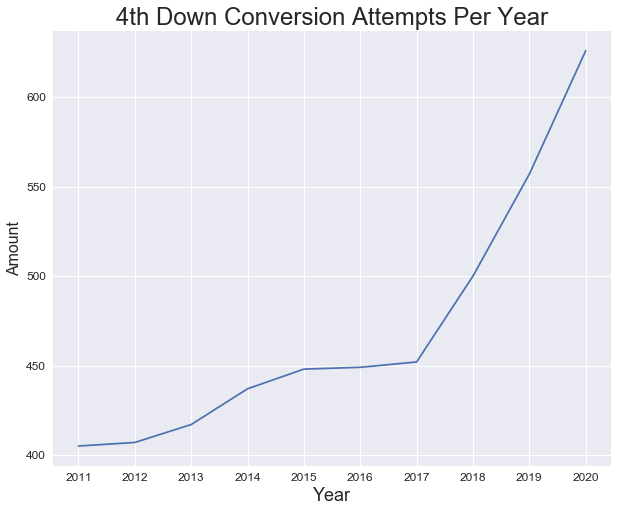

In [98]:
# Create a line graph to show how 4th down attempts have increased each year
conv_count = [405, 407, 417, 437, 448, 449, 452, 500, 557, 626]
col_names = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

plt.figure(figsize=(10,8))
sns.lineplot(col_names, conv_count, palette="Blues_d")
plt.title('4th Down Conversion Attempts Per Year', fontsize=24)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Amount', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./images/4th_attempts.png')
plt.show();

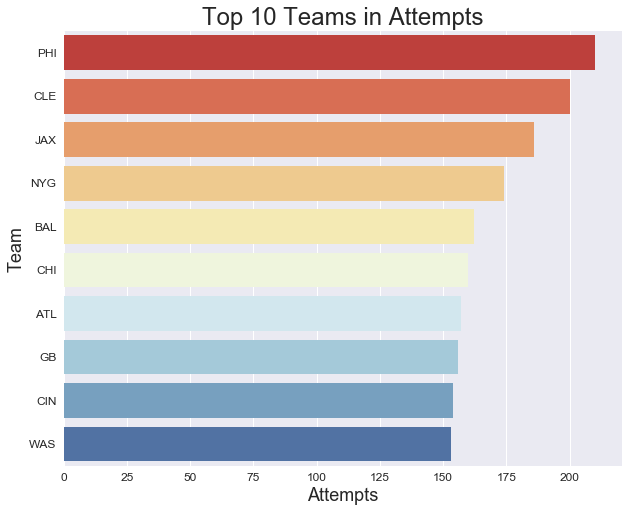

In [99]:
# Create a bar plot to show the attempts per team
team_attempts = [210, 200, 186, 174, 162, 160, 157, 156, 154, 153]
team_names = ['PHI', 'CLE', 'JAX', 'NYG', 'BAL', 'CHI', 'ATL', 'GB', 'CIN', 'WAS']

plt.figure(figsize=(10,8))
sns.barplot(team_attempts, team_names, palette="RdYlBu")
plt.title('Top 10 Teams in Attempts', fontsize=24)
plt.xlabel('Attempts', fontsize=18)
plt.ylabel('Team', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./images/team_attempts.png')
plt.show();

<Figure size 1440x1152 with 0 Axes>

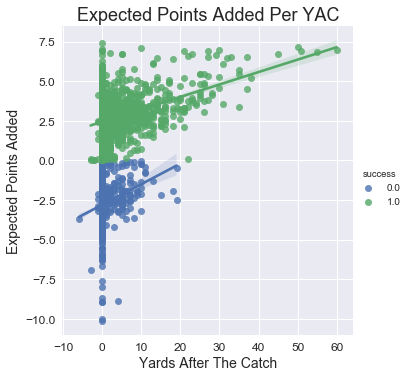

In [100]:
plt.figure(figsize=(20,16))
sns.lmplot(x='yards_after_catch', y='epa', hue='success', data=df)
plt.title('Expected Points Added Per YAC', fontsize=18)
plt.xlabel('Yards After The Catch', fontsize=14)
plt.ylabel('Expected Points Added', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./images/epa_per_yac.png')
plt.show();

In [101]:
def ydsnet_success(i):
    if i['success'] == 1.0:
        val = i['ydsnet']
    else:
        return
    return val
df['ydsnet_success'] = df.apply(ydsnet_success, axis=1)

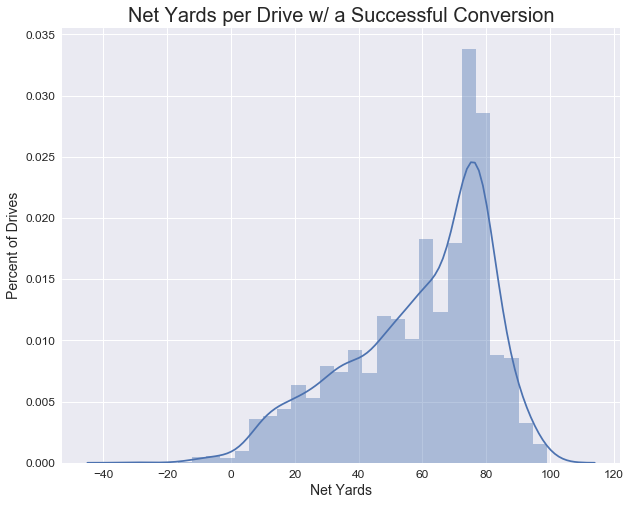

In [102]:
plt.figure(figsize=(10,8))
plt.title('Net Yards per Drive w/ a Successful Conversion', fontsize=20)
sns.distplot(df['ydsnet_success'])
plt.xlabel('Net Yards', fontsize=14)
plt.ylabel('Percent of Drives', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./images/successful_conversions.png')
plt.show();

### Drop columns that are no longer needed

In [103]:
df = df.drop(['season', 'week', 'home_team', 'away_team', 'posteam', 'defteam', 'sp', 'down', 'yards_gained', 'timeout_team', 
              'score_differential_post', 'no_score_prob', 'epa', 'wpa', 'complete_pass', 'incomplete_pass', 'interception', 
              'tackled_for_loss', 'fumble_lost', 'qb_hit', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'fumble', 
              'stadium', 'ydsnet_success'], axis=1)

In [104]:
df.columns

Index(['posteam_type', 'yardline_100', 'half_seconds_remaining', 'game_half',
       'drive', 'qtr', 'goal_to_go', 'ydstogo', 'ydsnet', 'shotgun',
       'no_huddle', 'qb_dropback', 'qb_scramble', 'pass_length',
       'pass_location', 'air_yards', 'yards_after_catch', 'run_location',
       'run_gap', 'timeout', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'score_differential', 'opp_td_prob',
       'td_prob', 'ep', 'wp', 'series', 'drive_play_count', 'drive_inside20',
       'div_game', 'surface', 'roof', 'pass', 'rush', 'success', 'off_rank',
       'def_rank'],
      dtype='object')

# Build the Model

### Create dummy variables to account for categorical values

In [105]:
df.dtypes

posteam_type                   object
yardline_100                  float64
half_seconds_remaining        float64
game_half                      object
drive                         float64
qtr                             int64
goal_to_go                      int64
ydstogo                         int64
ydsnet                        float64
shotgun                         int64
no_huddle                       int64
qb_dropback                   float64
qb_scramble                     int64
pass_length                    object
pass_location                  object
air_yards                     float64
yards_after_catch             float64
run_location                   object
run_gap                        object
timeout                       float64
posteam_timeouts_remaining    float64
defteam_timeouts_remaining    float64
score_differential            float64
opp_td_prob                   float64
td_prob                       float64
ep                            float64
wp          

In [106]:
dummy_postype = pd.get_dummies(df['posteam_type'])
dummy_postype.head()

away  home
49      0     1
181     0     1
208     1     0
323     1     0
511     1     0

In [107]:
dummy_half = pd.get_dummies(df['game_half'])
dummy_half.head()

Half1  Half2  Overtime
49       1      0         0
181      0      1         0
208      1      0         0
323      0      1         0
511      0      1         0

In [108]:
dummy_pass_length = pd.get_dummies(df['pass_length'])
dummy_pass_length.head()

0  deep  short
49   1     0      0
181  0     0      1
208  0     1      0
323  1     0      0
511  1     0      0

In [109]:
dummy_pass_loc = pd.get_dummies(df['pass_location'])
dummy_pass_loc.head()

0  left  middle  right
49   1     0       0      0
181  0     0       0      1
208  0     0       1      0
323  1     0       0      0
511  1     0       0      0

In [110]:
dummy_run_loc = pd.get_dummies(df['run_location'])
dummy_run_loc.head()

0  left  middle  right
49   0     0       1      0
181  1     0       0      0
208  1     0       0      0
323  0     1       0      0
511  1     0       0      0

In [111]:
dummy_run_gap = pd.get_dummies(df['run_gap'])
dummy_run_gap.head()

0  end  guard  tackle
49   1    0      0       0
181  1    0      0       0
208  1    0      0       0
323  0    1      0       0
511  1    0      0       0

In [112]:
dummy_surface = pd.get_dummies(df['surface'])
dummy_surface.head(10)

a_turf  astroplay  astroturf  fieldturf  fieldturf   grass  matrixturf  \
49        0          0          0          0           0      1           0   
181       0          0          0          0           0      1           0   
208       0          0          0          1           0      0           0   
323       0          0          0          1           0      0           0   
511       0          0          0          0           0      1           0   
533       0          0          0          0           0      1           0   
584       0          0          0          0           0      0           1   
708       0          0          0          0           0      0           1   
737       0          0          0          0           0      0           1   
743       0          0          0          0           0      0           1   

     sportturf  
49           0  
181          0  
208          0  
323          0  
511          0  
533          0  
584          0  
708          0  
737          0  
743          0

In [113]:
dummy_roof = pd.get_dummies(df['roof'])
dummy_roof.head()

closed  dome  open  outdoors
49        0     0     0         1
181       0     0     0         1
208       0     1     0         0
323       0     1     0         0
511       0     0     0         1

In [114]:
df = df.merge(dummy_postype, left_index=True, right_index=True)
df = df.merge(dummy_half, left_index=True, right_index=True)
df = df.merge(dummy_pass_length, left_index=True, right_index=True)
df = df.merge(dummy_pass_loc, left_index=True, right_index=True)
df = df.merge(dummy_run_loc, left_index=True, right_index=True)
df = df.merge(dummy_run_gap, left_index=True, right_index=True)
df = df.merge(dummy_surface, left_index=True, right_index=True)
df = df.merge(dummy_roof, left_index=True, right_index=True)
df.head()

posteam_type  yardline_100  half_seconds_remaining game_half  drive  qtr  \
49          home           1.0                   757.0     Half1    9.0    2   
181         home          16.0                    37.0     Half2   22.0    4   
208         away          34.0                  1442.0     Half1    3.0    1   
323         away          10.0                   900.0     Half2   17.0    4   
511         away          28.0                  1088.0     Half2   15.0    3   

     goal_to_go  ydstogo  ydsnet  shotgun  ...  astroturf  fieldturf  \
49            1        1    61.0        0  ...          0          0   
181           0        5    59.0        1  ...          0          0   
208           0        7    41.0        1  ...          0          1   
323           0        1    59.0        0  ...          0          1   
511           0        4    33.0        1  ...          0          0   

     fieldturf  grass matrixturf  sportturf  closed dome open  outdoors  
49            0     1          0          0       0    0    0         1  
181           0     1          0          0       0    0    0         1  
208           0     0          0          0       0    1    0         0  
323           0     0          0          0       0    1    0         0  
511           0     1          0          0       0    0    0         1  

[5 rows x 70 columns]

In [115]:
df = df.drop(['posteam_type', 'game_half', 'pass_length', 'pass_location', 'run_location', 'run_gap', 'surface', 'roof'], axis=1)
df.dtypes

yardline_100                  float64
half_seconds_remaining        float64
drive                         float64
qtr                             int64
goal_to_go                      int64
ydstogo                         int64
ydsnet                        float64
shotgun                         int64
no_huddle                       int64
qb_dropback                   float64
qb_scramble                     int64
air_yards                     float64
yards_after_catch             float64
timeout                       float64
posteam_timeouts_remaining    float64
defteam_timeouts_remaining    float64
score_differential            float64
opp_td_prob                   float64
td_prob                       float64
ep                            float64
wp                            float64
series                          int64
drive_play_count              float64
drive_inside20                float64
div_game                        int64
pass                          float64
rush        

## Model 1 - Decision Tree

### Import Libraries and Test Data

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [117]:
#create numpy arrays for predictors and target variables 
X = df.drop('success', axis=1).values
y = df['success'].values

In [118]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [119]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [120]:
print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_pred))

----------------------------------------
Accuracy Score:
0.8219858156028369
----------------------------------------
Confusion Matrix:
[[580 117]
 [134 579]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       697
         1.0       0.83      0.81      0.82       713

    accuracy                           0.82      1410
   macro avg       0.82      0.82      0.82      1410
weighted avg       0.82      0.82      0.82      1410



In [121]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(580, 117, 134, 579)

In [122]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))

Testing Accuracy for Decision Tree Classifier: 82.2%


### Feature Importance

In [123]:
# Feature importance
top_feats = clf.feature_importances_
top_feats

array([6.40313566e-02, 3.14636152e-02, 1.39711578e-02, 2.23059992e-03,
       8.19467762e-03, 4.47737208e-02, 1.19165894e-01, 1.07019706e-03,
       1.88587084e-03, 0.00000000e+00, 0.00000000e+00, 2.38999174e-02,
       8.41737704e-02, 2.77362532e-03, 3.72407660e-03, 1.48855220e-03,
       1.58151565e-02, 9.43437031e-02, 3.60567597e-02, 2.38924678e-02,
       2.04458244e-02, 2.25470465e-02, 2.05130017e-01, 5.65645045e-02,
       2.87799030e-03, 0.00000000e+00, 1.46002904e-03, 1.00164323e-02,
       2.00226965e-02, 2.12966642e-03, 3.05268835e-03, 6.08345434e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.01819739e-03,
       0.00000000e+00, 0.00000000e+00, 2.08890662e-03, 3.51488473e-03,
       0.00000000e+00, 4.08470955e-02, 2.65306203e-03, 1.26199319e-04,
       0.00000000e+00, 0.00000000e+00, 3.88665138e-04, 3.45626391e-03,
       0.00000000e+00, 5.61549631e-04, 2.57445982e-03, 2.86029316e-03,
       3.01407510e-03, 3.19943481e-03, 2.68830744e-03, 1.66219636e-03,
      

There appear to be a few variables that have zero importance on the model. Let's graph the data to see which ones should be dropped.

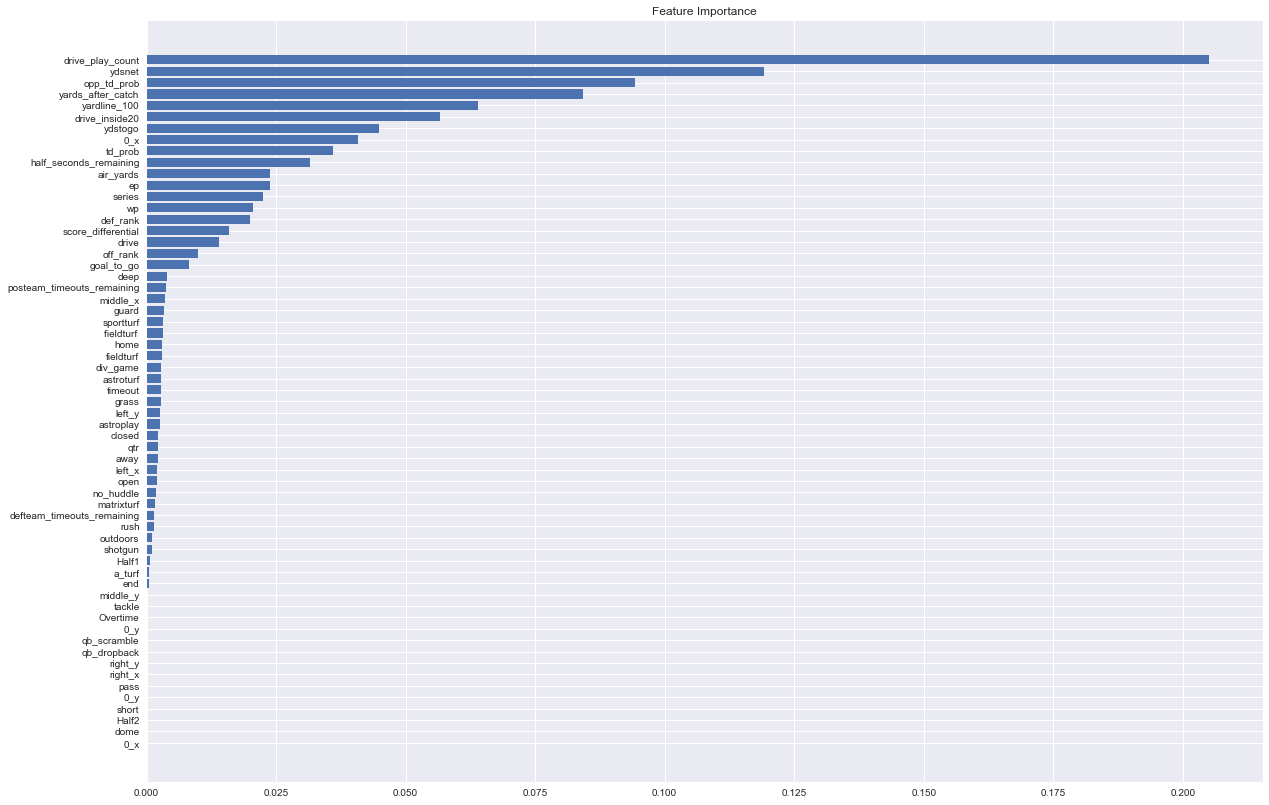

In [124]:
# creating list of column names
col_names = df.drop('success', axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

### Drop unimportant columns & re-evaluate until there are none left

In [125]:
# create a new dataset to do this with so it doesn't affect future models.
df1 = df.copy()

In [126]:
df = df.drop(['middle_y', 'tackle', 'Overtime', '0_y', 'qb_scramble', 'qb_dropback', 'right_y', 'right_x', 
              'pass', '0_y', 'short', 'Half2', 'dome', '0_x'], axis=1)

In [132]:
#create numpy arrays for predictors and target variables 
X = df.drop('success', axis=1).valuesk
y = df['success'].values

In [133]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [134]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [138]:
# Feature importance
top_feats = clf.feature_importances_
top_feats

array([0.06842624, 0.02212265, 0.00686084, 0.0022306 , 0.01016203,
       0.05624485, 0.12250043, 0.00112734, 0.        , 0.02481431,
       0.08350046, 0.00110385, 0.0050069 , 0.00601057, 0.0113237 ,
       0.09502035, 0.03499791, 0.03189217, 0.01264151, 0.02405417,
       0.20244139, 0.05649638, 0.00060835, 0.03195423, 0.01858811,
       0.02444876, 0.00153535, 0.00190888, 0.00206837, 0.00091252,
       0.00172573, 0.00400215, 0.00506965, 0.00184869, 0.00352386,
       0.00253767, 0.00153917, 0.00415429, 0.00281191, 0.00427734,
       0.00187718, 0.00119024, 0.002545  , 0.0018939 , 0.        ,
       0.        ])

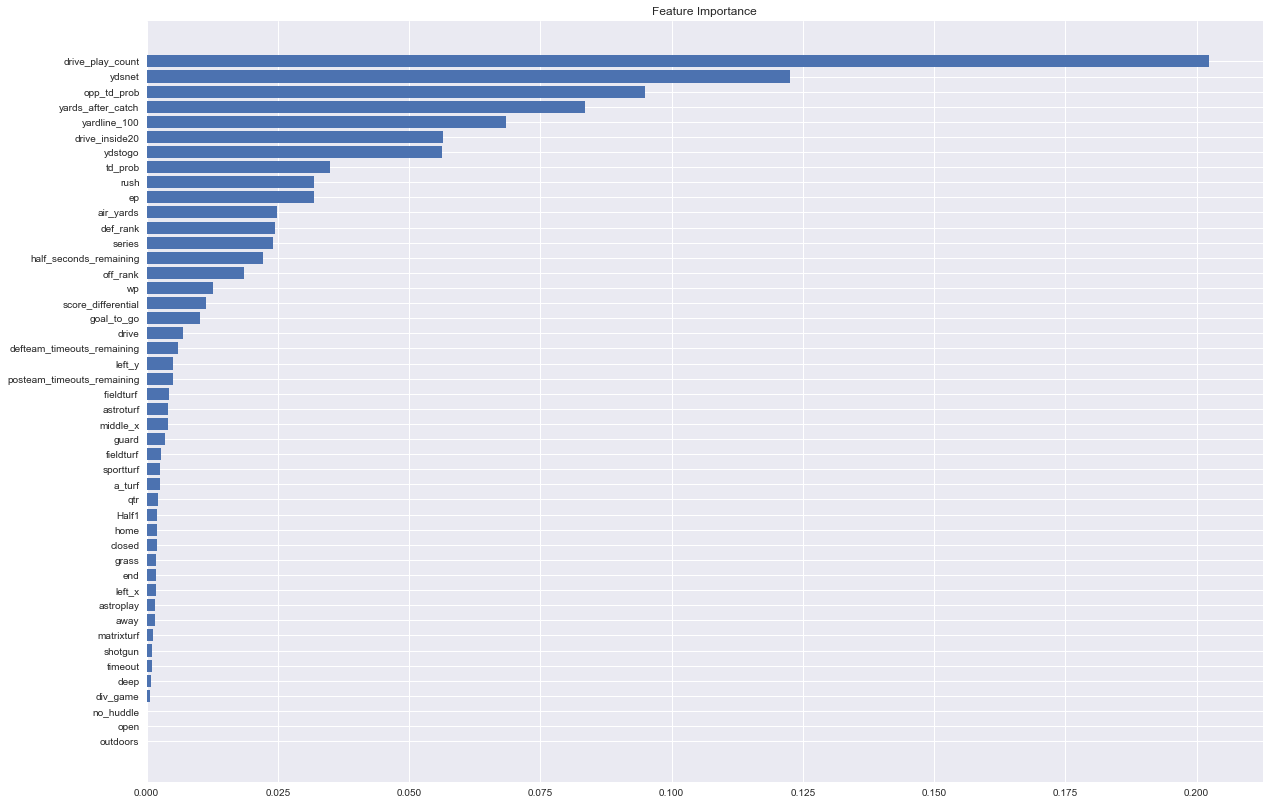

In [139]:
# creating list of column names
col_names = df.drop(['success'], axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

In [140]:
df = df.drop(['no_huddle', 'open', 'outdoors'], axis=1)

In [141]:
#create numpy arrays for predictors and target variables 
X = df.drop('success', axis=1).values
y = df['success'].values

In [142]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [143]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [147]:
# Feature importance
top_feats = clf.feature_importances_
top_feats

array([0.07280656, 0.02442439, 0.01097459, 0.00152086, 0.00914176,
       0.05388624, 0.11825873, 0.00112734, 0.02266989, 0.08152333,
       0.00158736, 0.00605322, 0.00474319, 0.01126593, 0.09703364,
       0.03917   , 0.02856533, 0.01650924, 0.02234427, 0.2049286 ,
       0.05818623, 0.00101391, 0.03195423, 0.01663469, 0.02220441,
       0.00296578, 0.00108679, 0.00250291, 0.        , 0.00172573,
       0.00491467, 0.00506965, 0.00038867, 0.00403081, 0.00253767,
       0.00153917, 0.00303119, 0.00054751, 0.00420794, 0.00268831,
       0.00119024, 0.00175947, 0.00128555])

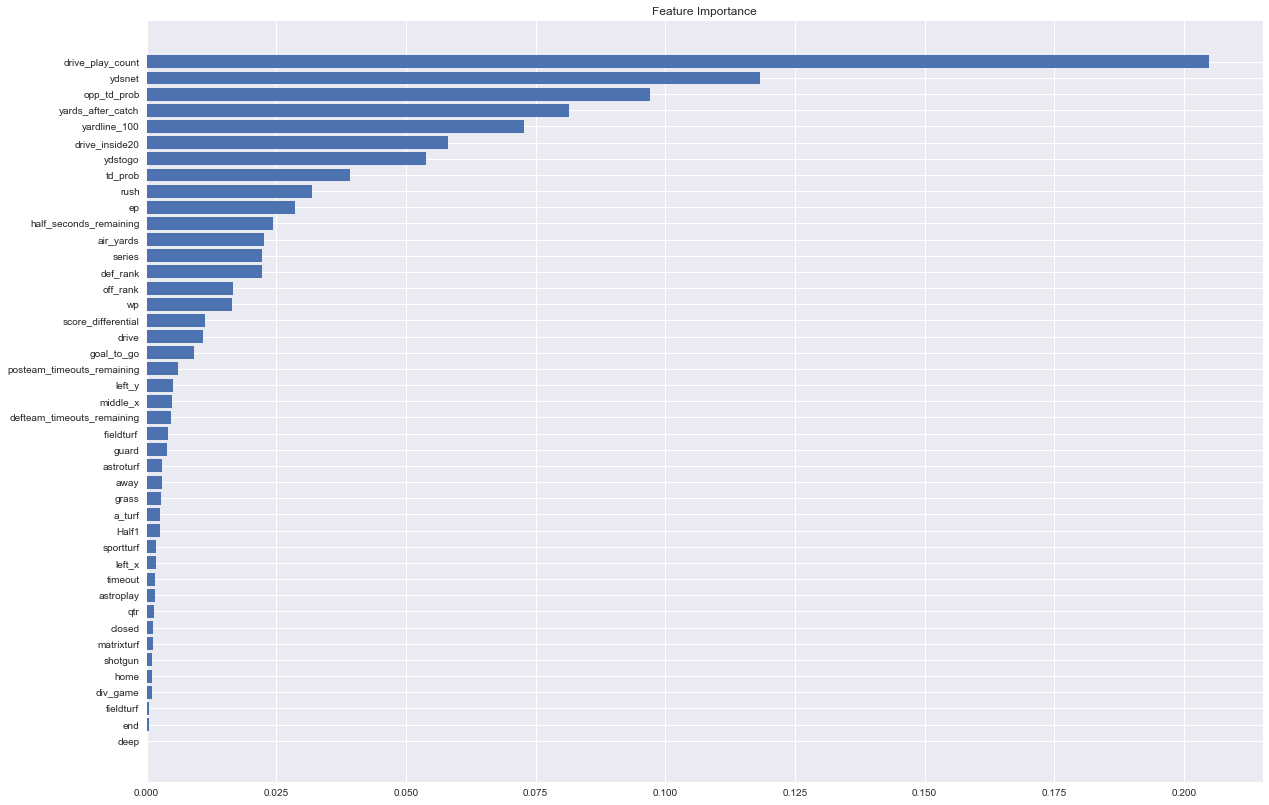

In [148]:
# creating list of column names
col_names = df.drop(['success'], axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

In [149]:
df = df.drop('deep', axis=1)

In [150]:
#create numpy arrays for predictors and target variables 
X = df.drop('success', axis=1).values
y = df['success'].values

In [151]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [152]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [156]:
# Feature importance
top_feats = clf.feature_importances_
top_feats

array([0.06851761, 0.02477116, 0.00874473, 0.00266513, 0.00914176,
       0.05031493, 0.11999719, 0.00110361, 0.02037339, 0.08466645,
       0.00277363, 0.00581802, 0.00408414, 0.00821235, 0.09813091,
       0.03791051, 0.02840104, 0.01392508, 0.02312642, 0.20762427,
       0.05818623, 0.00141947, 0.03341425, 0.0198048 , 0.02603538,
       0.00372295, 0.00082209, 0.        , 0.00111739, 0.00558385,
       0.00567799, 0.00147017, 0.00261134, 0.00156432, 0.00153917,
       0.00303119, 0.00165605, 0.00427734, 0.00248553, 0.00119024,
       0.00280235, 0.00128555])

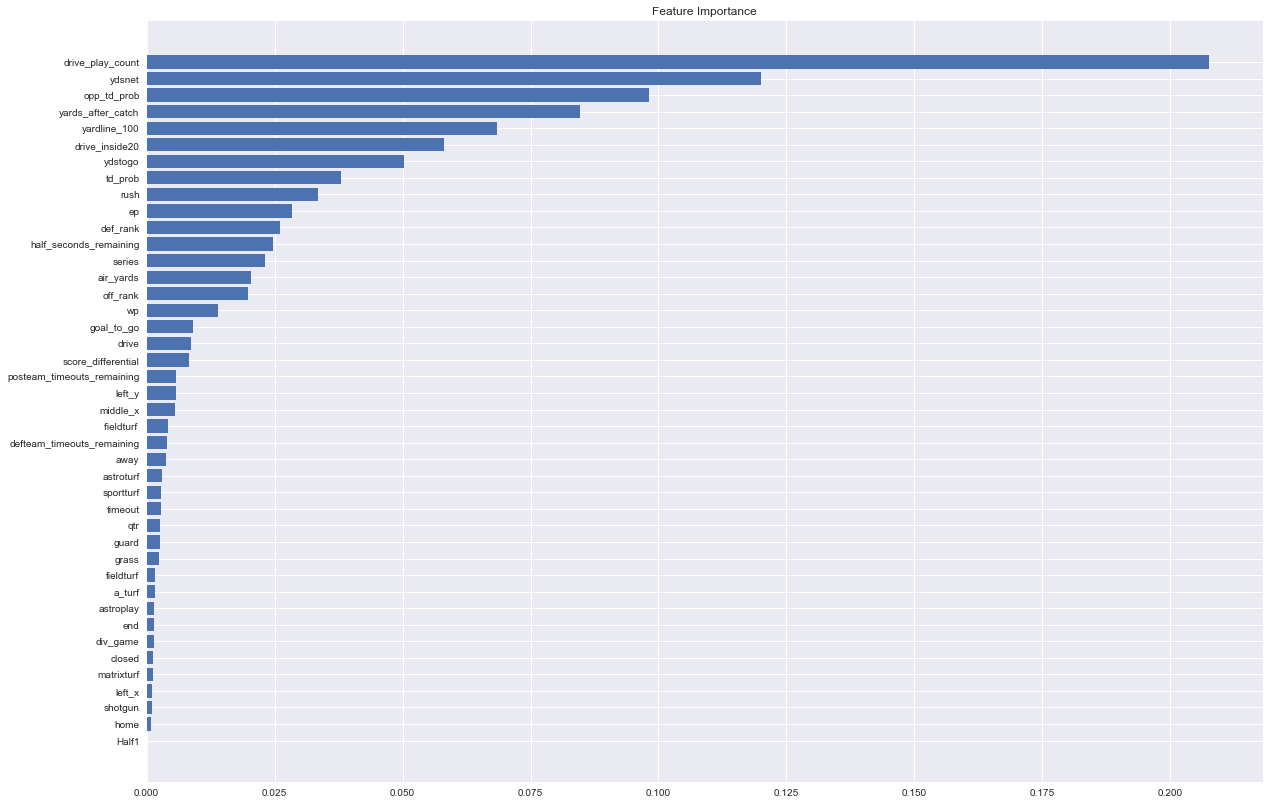

In [157]:
# creating list of column names
col_names = df.drop(['success'], axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

In [158]:
df = df.drop('Half1', axis=1)

In [159]:
#create numpy arrays for predictors and target variables 
X = df.drop('success', axis=1).values
y = df['success'].values

In [160]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [161]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [165]:
# Feature importance
top_feats = clf.feature_importances_
top_feats

array([0.07552657, 0.02679301, 0.01218957, 0.00152086, 0.00914176,
       0.05061276, 0.11502504, 0.00112734, 0.02338738, 0.08152333,
       0.00256332, 0.00515162, 0.00575709, 0.01129386, 0.09734274,
       0.03604295, 0.02431039, 0.01894977, 0.02022192, 0.20937055,
       0.05818623, 0.        , 0.03195423, 0.01535717, 0.02703408,
       0.00152086, 0.00332835, 0.00111739, 0.00400215, 0.00506965,
       0.00121669, 0.        , 0.00326189, 0.00257656, 0.00557376,
       0.00220356, 0.00420794, 0.00187718, 0.00119024, 0.00057633,
       0.0018939 ])

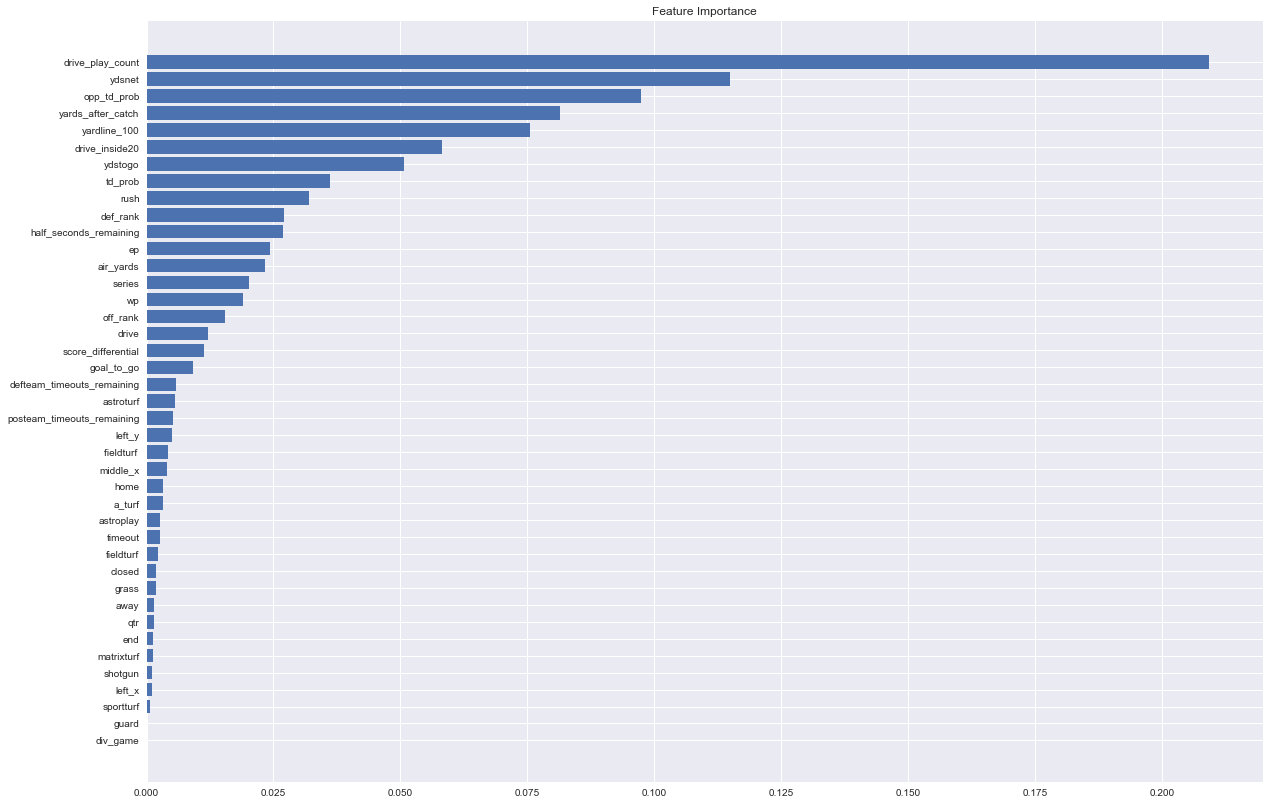

In [166]:
# creating list of column names
col_names = df.drop(['success'], axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

In [168]:
df = df.drop(['guard', 'div_game'], axis=1)

In [169]:
#create numpy arrays for predictors and target variables 
X = df.drop('success', axis=1).values
y = df['success'].values

In [170]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [171]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [172]:
# Feature importance
top_feats = clf.feature_importances_
top_feats

array([0.07090886, 0.02853114, 0.01353249, 0.00152086, 0.00914176,
       0.05205522, 0.11801577, 0.00112734, 0.02170016, 0.08314559,
       0.00201291, 0.00547607, 0.00575709, 0.01366604, 0.0971569 ,
       0.04094332, 0.02593897, 0.01545815, 0.02183946, 0.20868644,
       0.05818623, 0.03195423, 0.01602292, 0.02395453, 0.00082209,
       0.00281043, 0.00111739, 0.00552301, 0.00506965, 0.00038867,
       0.00156432, 0.00153917, 0.00303119, 0.00165605, 0.00420794,
       0.00248553, 0.00119024, 0.00057633, 0.00128555])

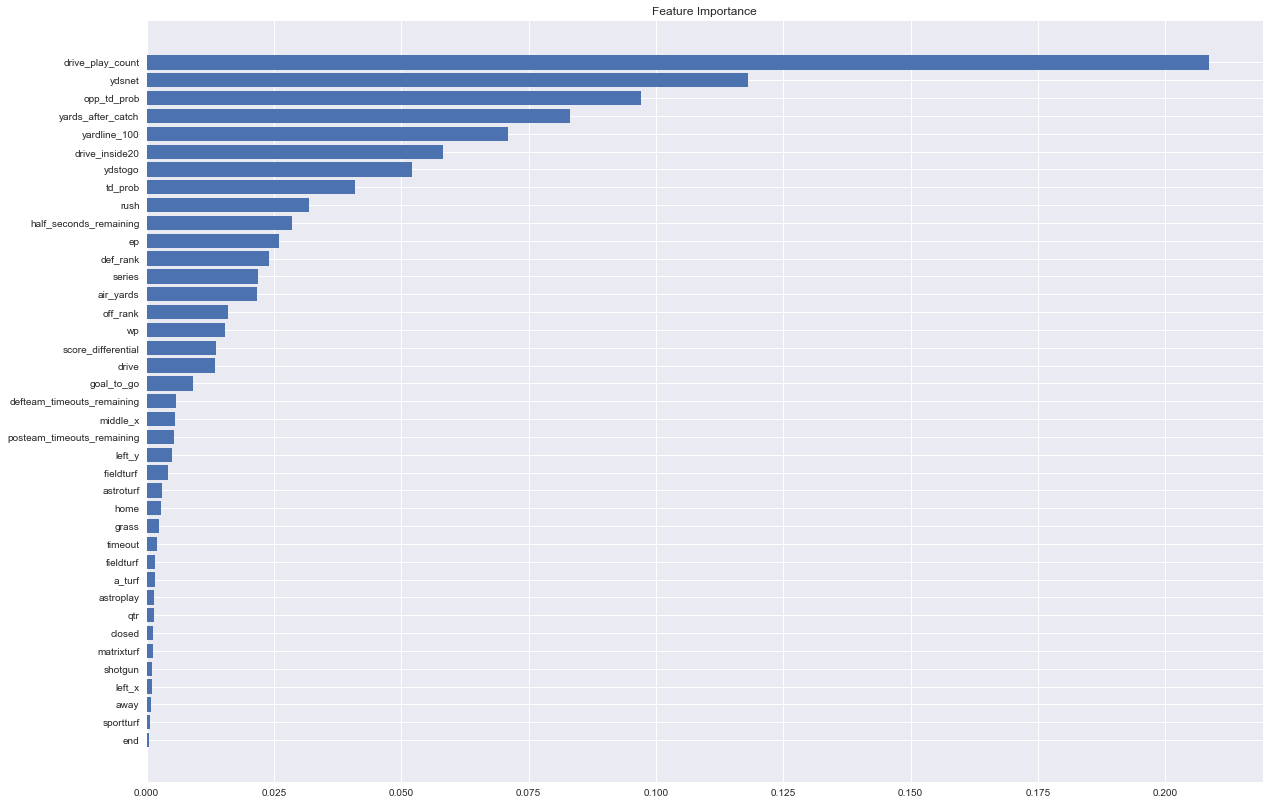

In [173]:
# creating list of column names
col_names = df.drop(['success'], axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

In [174]:
print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_pred))

----------------------------------------
Accuracy Score:
0.8163120567375887
----------------------------------------
Confusion Matrix:
[[578 119]
 [140 573]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       697
         1.0       0.83      0.80      0.82       713

    accuracy                           0.82      1410
   macro avg       0.82      0.82      0.82      1410
weighted avg       0.82      0.82      0.82      1410



In [175]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(578, 119, 140, 573)

In [176]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))

Testing Accuracy for Decision Tree Classifier: 81.63%


### Visualize the Decision Tree

In [177]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = col_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

C:\Users\daveb\anaconda3\envs\learn-env\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


The output is not very interpretable. Lets prune the tree.

### Use GridSearchCV to improve the model

In [182]:
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 79.14%


In [183]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [184]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                

In [185]:
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 82.71%
Mean Test Score: 83.05%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

In [188]:
dt_score = dt_grid_search.score(X_test, y_test)
print('Decision tree grid search: {:.4}%'.format(dt_score * 100))

Decision tree grid search: 83.05%


In [200]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=6)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [201]:
print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_pred))

----------------------------------------
Accuracy Score:
0.8326241134751773
----------------------------------------
Confusion Matrix:
[[605  92]
 [144 569]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       697
         1.0       0.86      0.80      0.83       713

    accuracy                           0.83      1410
   macro avg       0.83      0.83      0.83      1410
weighted avg       0.83      0.83      0.83      1410



In [202]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(605, 92, 144, 569)

In [203]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Precision: {:.4}%".format(precision * 100))
print("Recall: {:.4}%".format(recall * 100))

Precision: 86.08%
Recall: 79.8%


### Visualize the updated decision tree

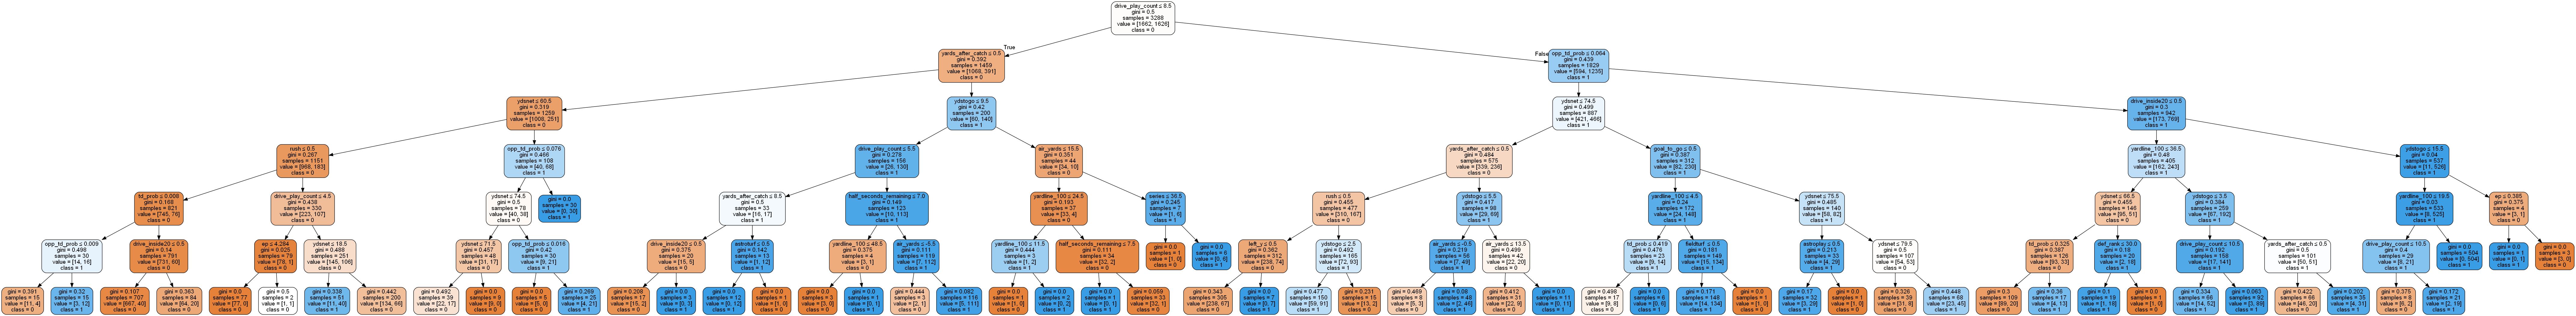

In [208]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = col_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('./images/4th_down_tree')
Image(graph.create_png())

## Model 2 - KNN

In [242]:
#create numpy arrays for predictors and target variables 
X = df1.drop('success', axis=1).values
y = df['success'].values

In [243]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [244]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

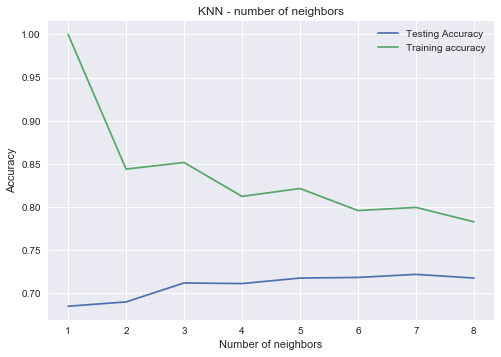

In [245]:
#Generate plot
plt.title('KNN - number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.savefig('./images/knn_lineplot.png')
plt.show()

In [246]:
#Setup a knn classifier with optimal k neighbors
knn = KNeighborsClassifier(n_neighbors=8)

In [247]:
#Fit the model
knn.fit(X_train,y_train)

#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_train,y_train)

0.7828467153284672

### Evaluate the Model

In [248]:
# get predictions
y_pred = knn.predict(X_test)

In [249]:
print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_pred))

----------------------------------------
Accuracy Score:
0.7177304964539007
----------------------------------------
Confusion Matrix:
[[577 120]
 [278 435]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74       697
         1.0       0.78      0.61      0.69       713

    accuracy                           0.72      1410
   macro avg       0.73      0.72      0.71      1410
weighted avg       0.73      0.72      0.71      1410



In [250]:
from sklearn.metrics import roc_auc_score, roc_curve 

y_pred_proba = knn.predict_proba(X_test)[:,1]

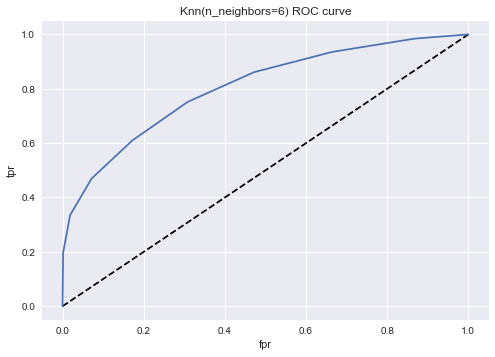

In [251]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=6) ROC curve')
plt.savefig('./images/knn_roc_curve.png')
plt.show()

In [252]:
#Area under ROC curve
roc_auc_score(y_test,y_pred_proba)

0.804291483637549

### Hyperparameter Tuning and Scaling

In [253]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train)
scaled_df_train.head()

0         1         2         3         4         5         6   \
0  2.166455 -0.849939  0.853172  0.732701 -0.340163 -0.096523 -2.008244   
1  0.836308 -1.099326  1.554305  0.732701 -0.340163  1.142382 -1.814918   
2  1.111511 -0.279618  0.853172  0.732701 -0.340163 -0.096523 -1.234942   
3 -0.906643 -1.019604  1.273852  0.732701 -0.340163  1.142382  0.775642   
4 -0.585573 -0.586242  0.993399  0.732701 -0.340163  2.794255  1.935594   

         7         8         9   ...        51        52        53        54  \
0  0.700343 -0.286243  0.675393  ... -0.161917 -0.566580 -0.083931  0.832003   
1  0.700343 -0.286243  0.675393  ... -0.161917 -0.566580 -0.083931  0.832003   
2  0.700343 -0.286243  0.675393  ... -0.161917 -0.566580 -0.083931 -1.201919   
3  0.700343 -0.286243  0.675393  ... -0.161917  1.764977 -0.083931 -1.201919   
4  0.700343  3.493540  0.675393  ... -0.161917 -0.566580 -0.083931  0.832003   

         55        56        57        58       59        60  
0 -0.169664 -0.269086 -0.378490 -0.382679 -0.07823  0.591400  
1 -0.169664 -0.269086 -0.378490 -0.382679 -0.07823  0.591400  
2 -0.169664  3.716290 -0.378490  2.613154 -0.07823 -1.690904  
3 -0.169664 -0.269086  2.642079 -0.382679 -0.07823 -1.690904  
4 -0.169664 -0.269086 -0.378490 -0.382679 -0.07823  0.591400  

[5 rows x 61 columns]

In [254]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}

In [255]:
#add cross validation hyperparameter
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(scaled_data_train, y_train)
# Predict on the test set
test_preds = knn_cv.predict(scaled_data_test)

### Re-evaluate the Model

In [256]:
print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_pred))

----------------------------------------
Accuracy Score:
0.7177304964539007
----------------------------------------
Confusion Matrix:
[[577 120]
 [278 435]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74       697
         1.0       0.78      0.61      0.69       713

    accuracy                           0.72      1410
   macro avg       0.73      0.72      0.71      1410
weighted avg       0.73      0.72      0.71      1410



In [257]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(577, 120, 278, 435)

In [258]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Precision: {:.4}%".format(precision * 100))
print("Recall: {:.4}%".format(recall * 100))

Precision: 78.38%
Recall: 61.01%


In [259]:
print(knn_cv.best_score_)
print(knn_cv.best_params_)

0.7369221411192214
{'n_neighbors': 33}


## Model 3 - Random Forest

In [260]:
#create numpy arrays for predictors and target variables 
X = df1.drop('success', axis=1).values
y = df['success'].values

In [261]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [262]:
rf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [263]:
print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))

Testing Accuracy for Random Forest Classifier: 83.05%


In [264]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       697
         1.0       0.84      0.83      0.83       713

    accuracy                           0.83      1410
   macro avg       0.83      0.83      0.83      1410
weighted avg       0.83      0.83      0.83      1410



In [265]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(581, 116, 123, 590)

In [266]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Precision: {:.4}%".format(precision * 100))
print("Recall: {:.4}%".format(recall * 100))

Precision: 83.57%
Recall: 82.75%


In [267]:
top_feats = rf.feature_importances_
top_feats

array([4.33901329e-02, 1.34432781e-02, 6.55109297e-03, 2.87916584e-03,
       4.62284844e-03, 5.11720927e-02, 1.63683589e-01, 6.00269935e-03,
       4.98541591e-04, 1.20833229e-02, 3.68577817e-03, 1.70344721e-02,
       1.38785478e-01, 2.12761176e-03, 2.49725844e-03, 3.50602050e-03,
       5.57454058e-03, 4.21587423e-02, 3.50456324e-02, 3.56642977e-02,
       1.20040890e-02, 1.06724161e-02, 1.64752967e-01, 1.14394892e-01,
       6.96079032e-04, 1.29114648e-02, 1.73297454e-02, 4.78313190e-03,
       5.33282125e-03, 5.25930469e-04, 1.03643303e-03, 1.84364307e-03,
       1.96538685e-03, 1.46347404e-04, 6.49274229e-03, 3.63036181e-03,
       7.57589268e-03, 6.60634158e-03, 5.41832893e-04, 6.00561855e-04,
       3.44397175e-04, 1.99181731e-02, 9.43316673e-04, 5.79977436e-03,
       3.73123869e-04, 2.20004537e-03, 1.51071070e-03, 2.46290925e-04,
       1.85082139e-04, 5.28045721e-04, 3.06345313e-04, 3.30990056e-04,
       2.11645440e-04, 2.03527760e-04, 2.84492164e-04, 2.70572535e-04,
      

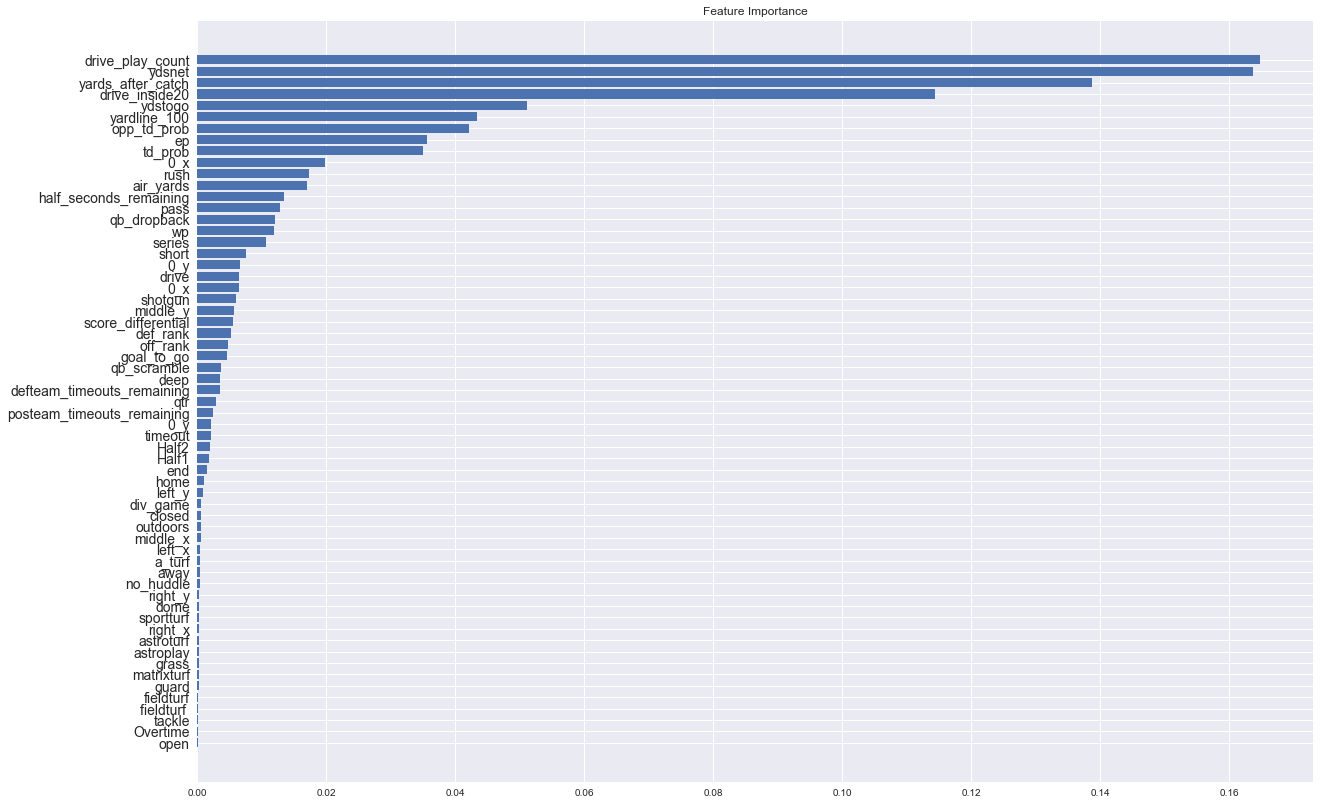

In [269]:
# creating list of column names
col_names = df1.drop('success', axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names, fontsize=14)

# Show plot
plt.show()

### Use GridSearchCV to improve the model

In [270]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

C:\Users\daveb\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\daveb\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Cross Validation Score for Random Forest Classifier: 81.60%


C:\Users\daveb\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [271]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [272]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 84.52%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 100}


In [273]:
rf_score = rf_grid_search.score(X_test, y_test)
print('Random forest grid search: {:.4}%'.format(rf_score * 100))

Random forest grid search: 85.53%


In [274]:
rf_clf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

C:\Users\daveb\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [275]:
print("Testing Accuracy for GridSearch CV Tree: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))

Testing Accuracy for GridSearch CV Tree: 83.26%


In [276]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       697
         1.0       0.88      0.77      0.82       713

    accuracy                           0.83      1410
   macro avg       0.84      0.83      0.83      1410
weighted avg       0.84      0.83      0.83      1410



In [288]:
print('-'*40)
print('Accuracy Score:')
print(accuracy_score(y_test, y_pred))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

print('-'*40)
print('Classification Matrix:')
print(classification_report(y_test, y_pred))

----------------------------------------
Accuracy Score:
0.8326241134751773
----------------------------------------
Confusion Matrix:
[[623  74]
 [162 551]]
----------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       697
         1.0       0.88      0.77      0.82       713

    accuracy                           0.83      1410
   macro avg       0.84      0.83      0.83      1410
weighted avg       0.84      0.83      0.83      1410



In [289]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(623, 74, 162, 551)

In [290]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Precision: {:.4}%".format(precision * 100))
print("Recall: {:.4}%".format(recall * 100))

Precision: 88.16%
Recall: 77.28%


In [279]:
top_feats = rf_clf.feature_importances_
top_feats

array([0.05215183, 0.02826377, 0.02398321, 0.00547076, 0.00690585,
       0.03919047, 0.12006889, 0.00801533, 0.00272249, 0.00517668,
       0.00233447, 0.02172711, 0.1012431 , 0.0027864 , 0.00794059,
       0.00931362, 0.02486924, 0.04255663, 0.05386002, 0.05849818,
       0.03432854, 0.02472172, 0.10171248, 0.05539315, 0.00663866,
       0.00542018, 0.00522516, 0.02494835, 0.02661482, 0.0046881 ,
       0.00470116, 0.00307558, 0.00418712, 0.00031679, 0.00467426,
       0.00251223, 0.00396405, 0.00212342, 0.00338594, 0.00369805,
       0.00393045, 0.00848207, 0.00253995, 0.00411154, 0.00247167,
       0.00423877, 0.00236868, 0.00253787, 0.00304673, 0.00152652,
       0.00073568, 0.00123733, 0.00458636, 0.00056841, 0.0047449 ,
       0.0021278 , 0.00182928, 0.00337945, 0.00170189, 0.00109405,
       0.00333219])

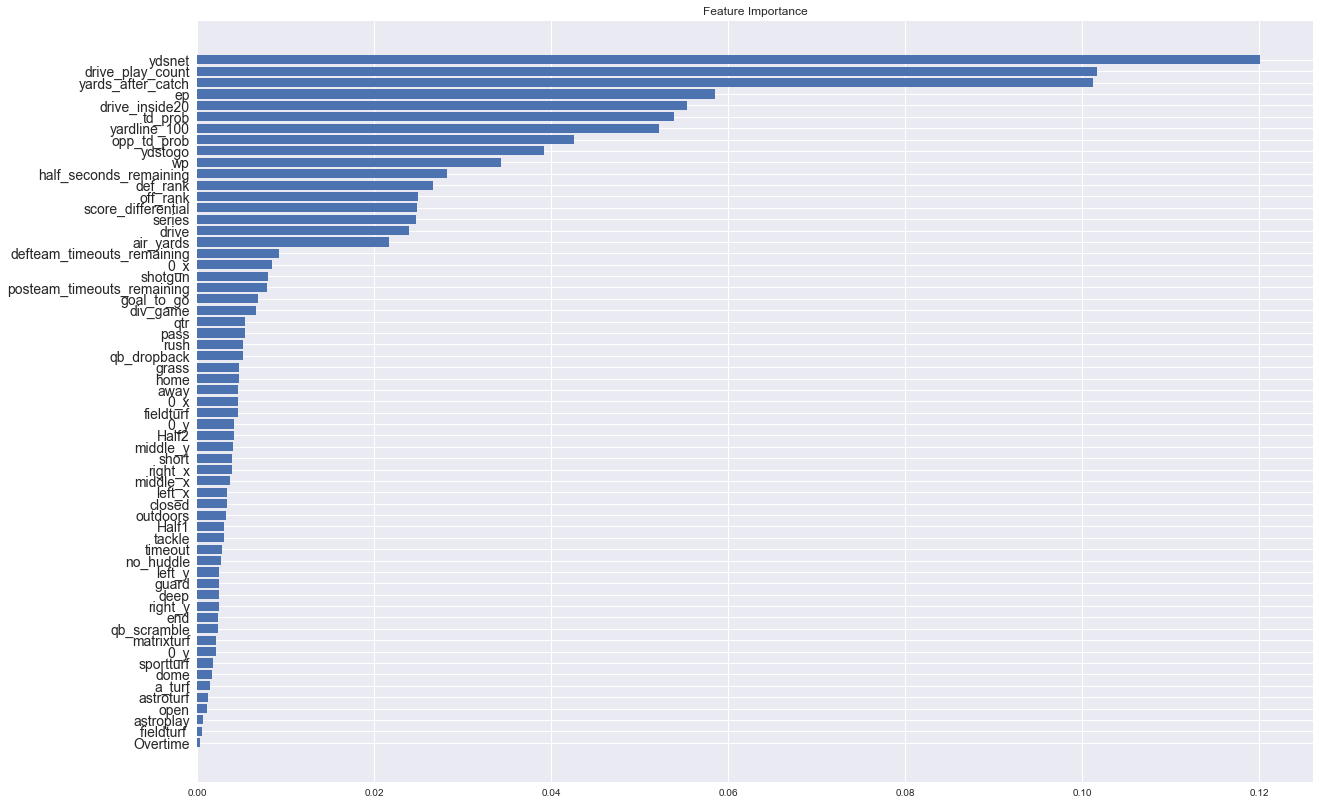

In [281]:
# creating list of column names
col_names = df1.drop('success', axis=1).columns
feat_names= list(col_names)

# Sort feature importances in ascending order
indices = np.argsort(top_feats)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]

# Create plot
plt.figure(figsize=(20,14))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), top_feats[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names, fontsize=14)

# Show plot
plt.show()

In [282]:
sorted(top_feats)

[0.0003167890724367637,
 0.0005684117305569758,
 0.0007356849586034574,
 0.0010940501434032095,
 0.0012373293317580842,
 0.0015265161077273547,
 0.0017018917724529615,
 0.001829283278737268,
 0.002123421917333781,
 0.0021277973871897332,
 0.00233446757045365,
 0.002368680747214684,
 0.0024716741980937216,
 0.002512228273670565,
 0.002537866976261716,
 0.0025399482454886426,
 0.002722491331903364,
 0.002786404628840544,
 0.0030467283087953997,
 0.003075581148563,
 0.00333219379718304,
 0.0033794528121793427,
 0.0033859415473808984,
 0.003698048055404866,
 0.003930454393788645,
 0.003964047677214348,
 0.004111541437285918,
 0.004187120592887407,
 0.004238765519565929,
 0.004586356228828515,
 0.00467426202255946,
 0.004688099620967591,
 0.004701163952909714,
 0.004744904305533556,
 0.005176683933958167,
 0.005225155944143187,
 0.005420177717548921,
 0.00547076248362239,
 0.006638659886976257,
 0.006905853436688154,
 0.007940585230870222,
 0.008015332427305327,
 0.00848206983617086,
 0.009

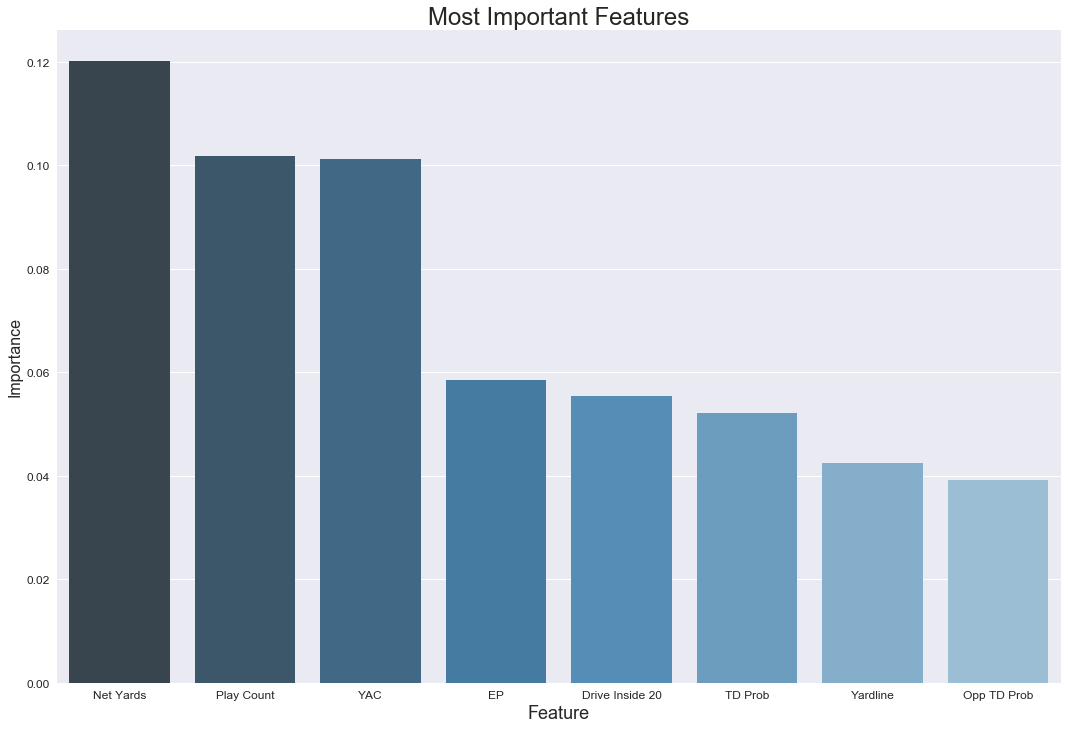

In [287]:
feat_per = [0.1200688863323353, 0.10171248048677668, 0.10124310191786108, 0.05849817636210371, 0.05539315262731963, 
            0.05215183282751075, 0.042556629689838185, 0.039190465942191555]
col_names = ['Net Yards', 'Play Count', 'YAC', 'EP', 'Drive Inside 20', 'TD Prob', 'Yardline', 'Opp TD Prob']

plt.figure(figsize=(18,12))
sns.barplot(col_names, feat_per, palette="Blues_d")
plt.title('Most Important Features', fontsize=24)
plt.xlabel('Feature', fontsize=18)
plt.ylabel('Importance', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./images/features.png')
plt.show();

# Conclusion

The Random Forest model is the best fit for this dataset. The accuracy matched the decision tree model at 83.26%, but precision was over 2% better at 88.16%. In this case, precision would represent the conversion attempts that appear to have succeeded, but actually failed. Recall would represent the attempts that appear to have failed, but acutally succeeded. Because a turnover is worse than a punt or field goal, precision is the more important measurement here.

Going forward, teams should consider net yards, play count, yards after the catch, expected points, drive inside the 20, TD probability, yardline and oppenent's TD probability on the next drive. These are the most important features of the algorithm and play a huge part in determining if a conversion is successful.